### Credit Card Customers

Importing all necessary modules

In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PowerTransformer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

import category_encoders as ce

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier

from scipy import stats
import statsmodels.stats.power as power

from imblearn.pipeline import Pipeline as Pipe
from itertools import combinations
from imblearn.combine import SMOTEENN

from catboost import Pool, CatBoostClassifier, EShapCalcType, EFeaturesSelectionAlgorithm
from lightgbm import LGBMClassifier
import optuna
from optuna.samplers import TPESampler

import category_encoders as ce
!pip install -q BorutaShap
from BorutaShap import BorutaShap
import shap

np.random.seed(123)
clear_output()

In [2]:
# defining the path to the dataset and target name 
data_root = 'BankChurners.csv'
TARGET_NAME = 'Attrition_Flag'

In [3]:
# load dataset in dataframe
df = pd.read_csv(data_root)

Next we define helper functions:
* show_proba_calibration_plots: displays probability threshold, that helps to increase recall, precision or F-score
* report: displays the estimators results - metrics
* reduce_memory: transforms the input pandas dataframe dtypes into lower memory size if possible
* plot_ROC: displays Area under curve plots to visualize roc_auc score
* vote: helps to apply majority voting if we use multiple estimators
* cross_validation: displays cross_validation results and mean score
* statistic_output, effect_size, categorical_stats: helper functions to make statistical tests as for numerical rather than categorical features to see if they have any statistical impact on target variable

In [23]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])
    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

def report(y_train, y_train_pred, y_test, y_test_pred, y_train_proba=None, y_test_proba=None):
    print('Train\n', classification_report(y_train, y_train_pred, digits=3))
    print('Test\n', classification_report(y_test, y_test_pred, digits=3))
    if y_train_proba is not None and y_test_proba is not None:
        roc_train, roc_test = roc_auc_score(y_train, y_train_proba), roc_auc_score(y_test, y_test_proba)
        print(f'Train ROC_AUC: {roc_train:.3f}, Test ROC_AUC: {roc_test:.3f}')
    print('Confusion Matrix', '\n', pd.crosstab(y_test, y_test_pred))

def reduce_memory(df, verbose=0):
    if verbose != 0:
        start_mem = df.memory_usage().sum() / 1024 ** 2
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)[:4] != 'uint' and str(col_type) != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif str(col_type)[:4] != 'uint':
            df[col] = df[col].astype('category')
    if verbose != 0:
        end_mem = df.memory_usage().sum() / 1024 ** 2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

def roc_plot(y_true, probs):
    fpr, tpr, threshold = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def vote(predictions: list, weights: list):
    predictions = np.asarray(predictions).T
    maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=weights)), axis=1, arr=predictions)
    return maj_vote

def cross_validation(clf, X, y, scoring='f1'):
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=10, scoring=scoring, n_jobs=-1)
    print(f'Меры правильности перекрекстной оценки: {scores}')
    print(f'Точность перекретсной оценки: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
    return scores

def effect_size(factor_a, factor_b, cohen=True, desired_power=0.8, alpha=0.05):
    n1, n2 = len(factor_a), len(factor_b)
    s1, s2 = factor_a.std(ddof=1), factor_b.std(ddof=1)
    df = (s1 ** 2 / n1 + s2 ** 2 / n2) ** 2 / \
          ((s1 ** 2 / n1) ** 2 / (n1 - 1) + (s2 ** 2 / n2) ** 2 / (n2 - 1))
    if cohen:
        sigma_pooled = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
        return np.abs(factor_a.mean() - factor_b.mean()) / sigma_pooled, df
    else:
        return power.tt_ind_solve_power(effect_size=None, nobs1=len(factor_a), alpha=alpha, power=desired_power,
                                        ratio=len(factor_b)/len(factor_a), alternative='two-sided'), df
    
def statistic_output(*columns, df=df, cat=False, target=TARGET_NAME, alpha=0.05, sample_size=0):
    data = df.copy()
    data.drop_duplicates(inplace=True)
    if sample_size == 0:
        sample_size = int(0.05 * len(data))
    if not cat:
        columns = data.drop(target, axis=1).select_dtypes(exclude=['category', 'object']).columns
        for column in columns:
            df_sampled = data[[column, target]].sample(sample_size, random_state=1)
            factor_a = df_sampled.loc[df_sampled[target] == 0][column]   
            factor_b = df_sampled.loc[df_sampled[target] == 1][column]
            var_a, var_b = factor_a.var(), factor_b.var()   
            _, pvalue = stats.shapiro(df_sampled[column])
            if pvalue >= alpha:
                _, pvalue = stats.ttest_ind(factor_a, factor_b, equal_var=False)
                test = power.TTestIndPower()
                eff_size, deg_free = effect_size(factor_a, factor_b, cohen=False)
                pow = test.power(effect_size=eff_size, nobs1=len(factor_a), alpha=alpha, df=deg_free, 
                                 ratio=len(factor_b)/len(factor_a), alternative='two-sided')
            else:
                if len(factor_a) == 0 or len(factor_b) == 0:
                    continue
                _, pvalue = stats.mannwhitneyu(factor_a, factor_b)
                pow, eff_size = None, None
            if pvalue < alpha:
                result = f'with effect_size = {eff_size:.4f} and ttest power {pow*100:.2f}%' if pow is not None else ''
                print(f'Factor "{column}" has statistical impact on target (var_a: {var_a:.2f}, var_b: {var_b:.2f}). {result}')
            else:
                print(f'Factor "{column}" does not affect target.')
    else:
        for column in columns:
            print(column)
            categories = data[column].unique().tolist()
            for pair in combinations(categories, r=2):
                a, b = pair
                if a != b:
                    data_ = data.loc[data[column].isin(pair), ['CLIENTNUM', column, target]].sample(sample_size, random_state=1)
                    table = data_.pivot_table(values='CLIENTNUM', index=column, columns=target, aggfunc='count')
                    try:
                        _, pvalue, _, _ = stats.chi2_contingency(table, correction=False)
                    except ValueError:
                        continue
                    if pvalue >= alpha:
                        print(f'Categories {a} and {b} can be united. P-value: {pvalue:.6f}')
                    else:
                        print(f'Categories {a} and {b} have different frequencies with target.')
                        
def categorical_stats(df=df, target=TARGET_NAME, alpha=0.05, sample_size=500):
    data = df.copy().sample(sample_size)
    columns_to_analize = data.select_dtypes(include=['category', 'object']).columns
    weak_list = []
    for factor in columns_to_analize:
        if factor == target:
            continue
        print(f'{factor}')
        table = pd.crosstab(data[factor], data[TARGET_NAME])
        p_value = stats.chi2_contingency(table, correction=False)[1]
        if p_value < alpha:
            print(f'Feature {factor} has statistical impact on target. P-value: {p_value:.6f}')
        else:
            weak_list.append(factor)
    if len(weak_list) > 0:
        print(f'Statistically weak categorical features: ', *weak_list)

### Some EDA and data visualisations

In [5]:
df.sample(8).transpose()

4697  \
CLIENTNUM                                                   716093133   
Attrition_Flag                                      Existing Customer   
Customer_Age                                                       38   
Gender                                                              F   
Dependent_count                                                     2   
Education_Level                                            Uneducated   
Marital_Status                                                 Single   
Income_Category                                           $40K - $60K   
Card_Category                                                    Blue   
Months_on_book                                                     31   
Total_Relationship_Count                                            5   
Months_Inactive_12_mon                                              2   
Contacts_Count_12_mon                                               2   
Credit_Limit                                                  12228.0   
Total_Revolving_Bal                                              2137   
Avg_Open_To_Buy                                               10091.0   
Total_Amt_Chng_Q4_Q1                                            0.553   
Total_Trans_Amt                                                  3831   
Total_Trans_Ct                                                     68   
Total_Ct_Chng_Q4_Q1                                             0.511   
Avg_Utilization_Ratio                                           0.175   
Naive_Bayes_Classifier_Attrition_Flag_Card_Cate...           0.000117   
Naive_Bayes_Classifier_Attrition_Flag_Card_Cate...            0.99988   

                                                                 1377  \
CLIENTNUM                                                   770662383   
Attrition_Flag                                      Existing Customer   
Customer_Age                                                       38   
Gender                                                              M   
Dependent_count                                                     2   
Education_Level                                              Graduate   
Marital_Status                                                 Single   
Income_Category                                           $40K - $60K   
Card_Category                                                    Blue   
Months_on_book                                                     24   
Total_Relationship_Count                                            6   
Months_Inactive_12_mon                                              3   
Contacts_Count_12_mon                                               2   
Credit_Limit                                                  14632.0   
Total_Revolving_Bal                                              1158   
Avg_Open_To_Buy                                               13474.0   
Total_Amt_Chng_Q4_Q1                                            0.501   
Total_Trans_Amt                                                  1399   
Total_Trans_Ct                                                     36   
Total_Ct_Chng_Q4_Q1                                               0.5   
Avg_Utilization_Ratio                                           0.079   
Naive_Bayes_Classifier_Attrition_Flag_Card_Cate...            0.00018   
Naive_Bayes_Classifier_Attrition_Flag_Card_Cate...            0.99982   

                                                                 3679  \
CLIENTNUM                                                   714622833   
Attrition_Flag                                      Existing Customer   
Customer_Age                                                       47   
Gender                                                              M   
Dependent_count                                                     3   
Education_Level                                            Uneducated   
Marital_Status                                  

In [6]:
# remove two last columns as the author suggests
df = df.iloc[:, :-2]
print(f'Total columns {len(df.columns)}')

# check for duplicates
print(f'Number of duplicates: {df.duplicated().astype(int).sum()}')
df.drop_duplicates(inplace=True)

Total columns 21
Number of duplicates: 0


In [7]:
# common characteristics for numerical features: 
# it does not seem, that there any extreme values in data
# some of the columns may follow normal distribution as their means and medians are close
df.describe()

CLIENTNUM  Customer_Age  Dependent_count  Months_on_book  \
count  1.012700e+04  10127.000000     10127.000000    10127.000000   
mean   7.391776e+08     46.325960         2.346203       35.928409   
std    3.690378e+07      8.016814         1.298908        7.986416   
min    7.080821e+08     26.000000         0.000000       13.000000   
25%    7.130368e+08     41.000000         1.000000       31.000000   
50%    7.179264e+08     46.000000         2.000000       36.000000   
75%    7.731435e+08     52.000000         3.000000       40.000000   
max    8.283431e+08     73.000000         5.000000       56.000000   

       Total_Relationship_Count  Months_Inactive_12_mon  \
count              10127.000000            10127.000000   
mean                   3.812580                2.341167   
std                    1.554408                1.010622   
min                    1.000000                0.000000   
25%                    3.000000                2.000000   
50%                    4.000000                2.000000   
75%                    5.000000                3.000000   
max                    6.000000                6.000000   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
count           10127.000000  10127.000000         10127.000000   
mean                2.455317   8631.953698          1162.814061   
std                 1.106225   9088.776650           814.987335   
min                 0.000000   1438.300000             0.000000   
25%                 2.000000   2555.000000           359.000000   
50%                 2.000000   4549.000000          1276.000000   
75%                 3.000000  11067.500000          1784.000000   
max                 6.000000  34516.000000          2517.000000   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
count     10127.000000          10127.000000     10127.000000    10127.000000   
mean       7469.139637              0.759941      4404.086304       64.858695   
std        9090.685324              0.219207      3397.129254       23.472570   
min           3.000000              0.000000       510.000000       10.000000   
25%        1324.500000              0.631000      2155.500000       45.000000   
50%        3474.000000              0.736000      3899.000000       67.000000   
75%        9859.000000              0.859000      4741.000000       81.000000   
max       34516.000000              3.397000     18484.000000      139.000000   

       Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
count         10127.000000           10127.000000  
mean              0.712222               0.274894  
std               0.238086               0.275691  
min               0.000000               0.000000  
25%               0.582000               0.023000  
50%               0.702000               0.176000  
75%               0.818000               0.503000  
max               3.714000               0.999000

In [8]:
# common characteristics for categorical features
# there are not high cardinality in here, seems it would be fine to use one-hot encoding
df.describe(include=['object'])

Attrition_Flag Gender Education_Level Marital_Status  \
count               10127  10127           10127          10127   
unique                  2      2               7              4   
top     Existing Customer      F        Graduate        Married   
freq                 8500   5358            3128           4687   

       Income_Category Card_Category  
count            10127         10127  
unique               6             4  
top     Less than $40K          Blue  
freq              3561          9436

In [9]:
# overall statistics
# good news: there are no missing values in dataset (missingno visualisation is not needed)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

In [10]:
# we can observe class imbalance in data
# next we will try three ways to handle it after predicting on raw data with base model
# 1) SMOTEENN - that generates new sinthetical samples and discards samples that are close
# to the decision boundary
# 2) Use in-built class_weight attributes in models (as alt. sklearn provides a method:
# sklearn.utils.class_weight.compute_class_weight) to penalize the loss function
# 3) Hybrid of sampling (SMOTE) and class_weight methods
df[TARGET_NAME].value_counts(normalize=True)

Existing Customer    0.83934
Attrited Customer    0.16066
Name: Attrition_Flag, dtype: float64

In [11]:
# let's reduce memory usage to speed up and optimize our calculations
df = reduce_memory(df, verbose=123)

Memory usage of dataframe is 1.70 MB
Memory usage after optimization is: 0.48 MB
Decreased by 71.5%


#### Some useful data visualizations

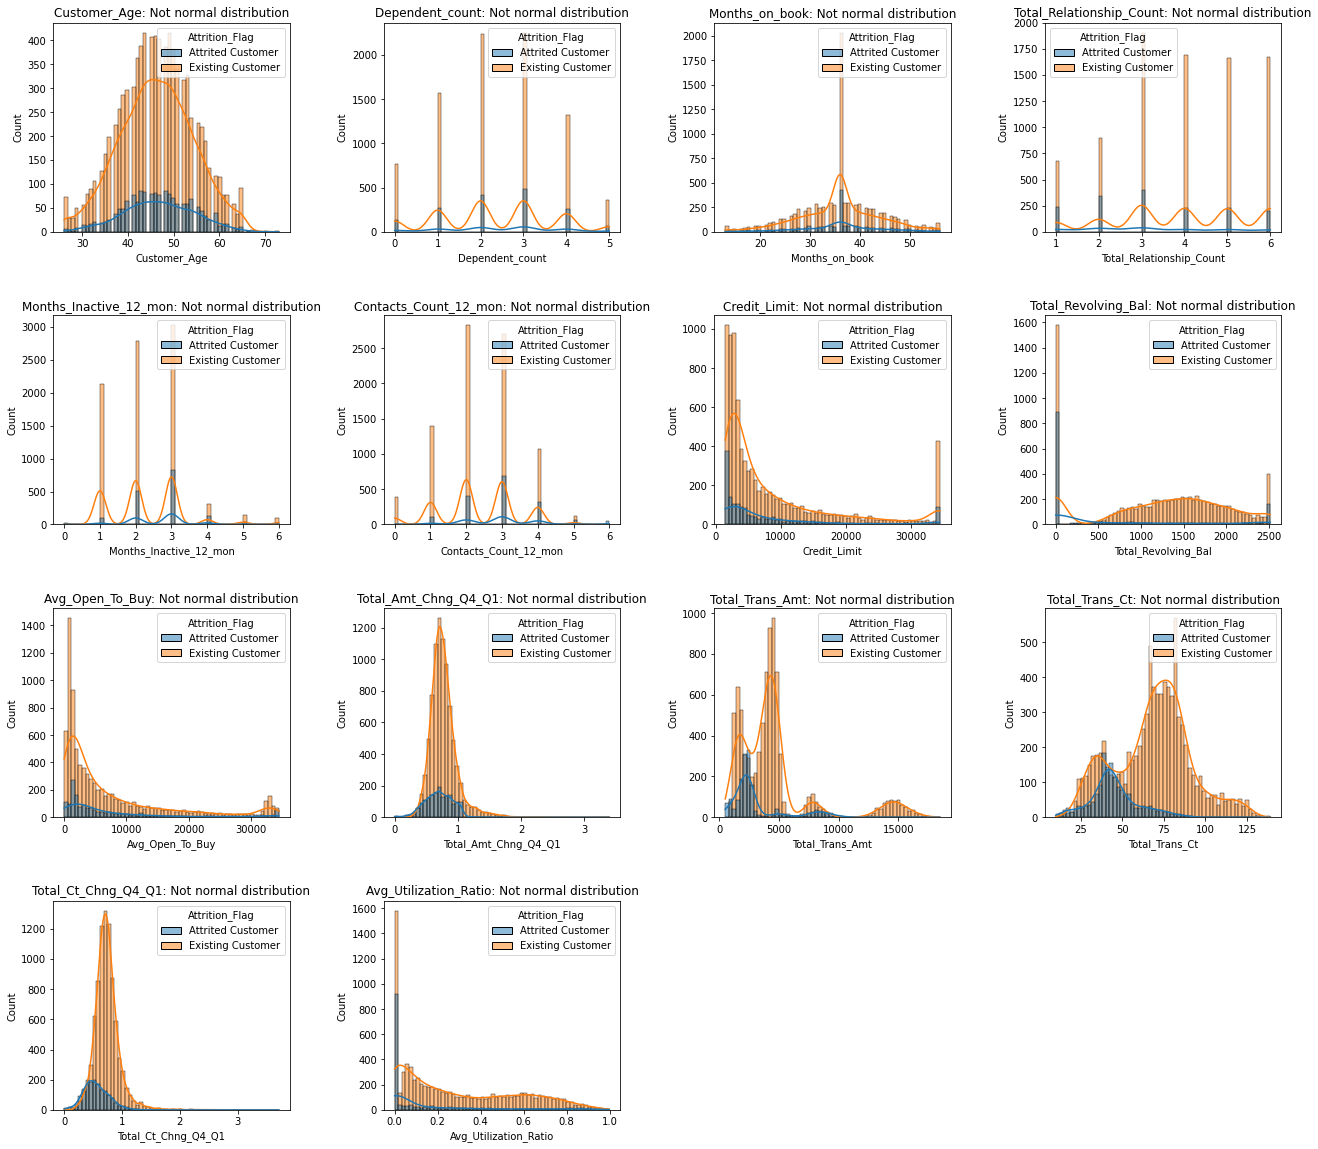

In [12]:
numerical_cols = df.select_dtypes(include=[np.int8, np.int16, np.float32]).columns.tolist()

plt.figure(figsize=(22, 20))
for idx, column in enumerate(numerical_cols):
    plt.subplot(4, 4, idx + 1)
    dist = 'Normal Distribution' if stats.shapiro(df[column].sample(1000))[1] > 0.05 else 'Not normal distribution'
    plt.title(f'{column}: {dist}')
    sns.histplot(data=df, x=column, hue=TARGET_NAME, bins=60, kde=True)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()
# Age is close to normal distribution
# We can clearly see that numerical data has different distribution via target
# also there are strange tail in Credit_Limit and Total_Revolvong_Bal
# we will inspect them with IQR boxplots
# months_on_book have large amount of median values
# also we have to admit that there are some count features, which sounds good for 
# boosting models

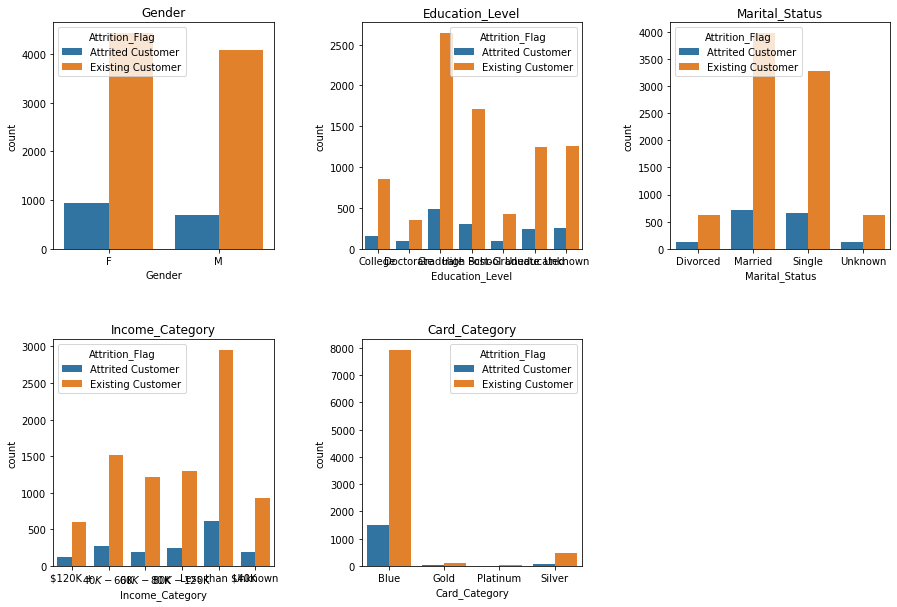

In [13]:
categorical_cols = df.drop(TARGET_NAME, axis=1).select_dtypes(include=['category']).columns

plt.figure(figsize=(15, 10))
for idx, column in enumerate(categorical_cols, 1):
    plt.subplot(2, 3, idx)
    plt.title(f'{column}')
    sns.countplot(x=column, hue=TARGET_NAME, data=df)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()
# for the first look there are no any significant insites
# for card_category it is better to apply label smoothing if not using one-hot encoding

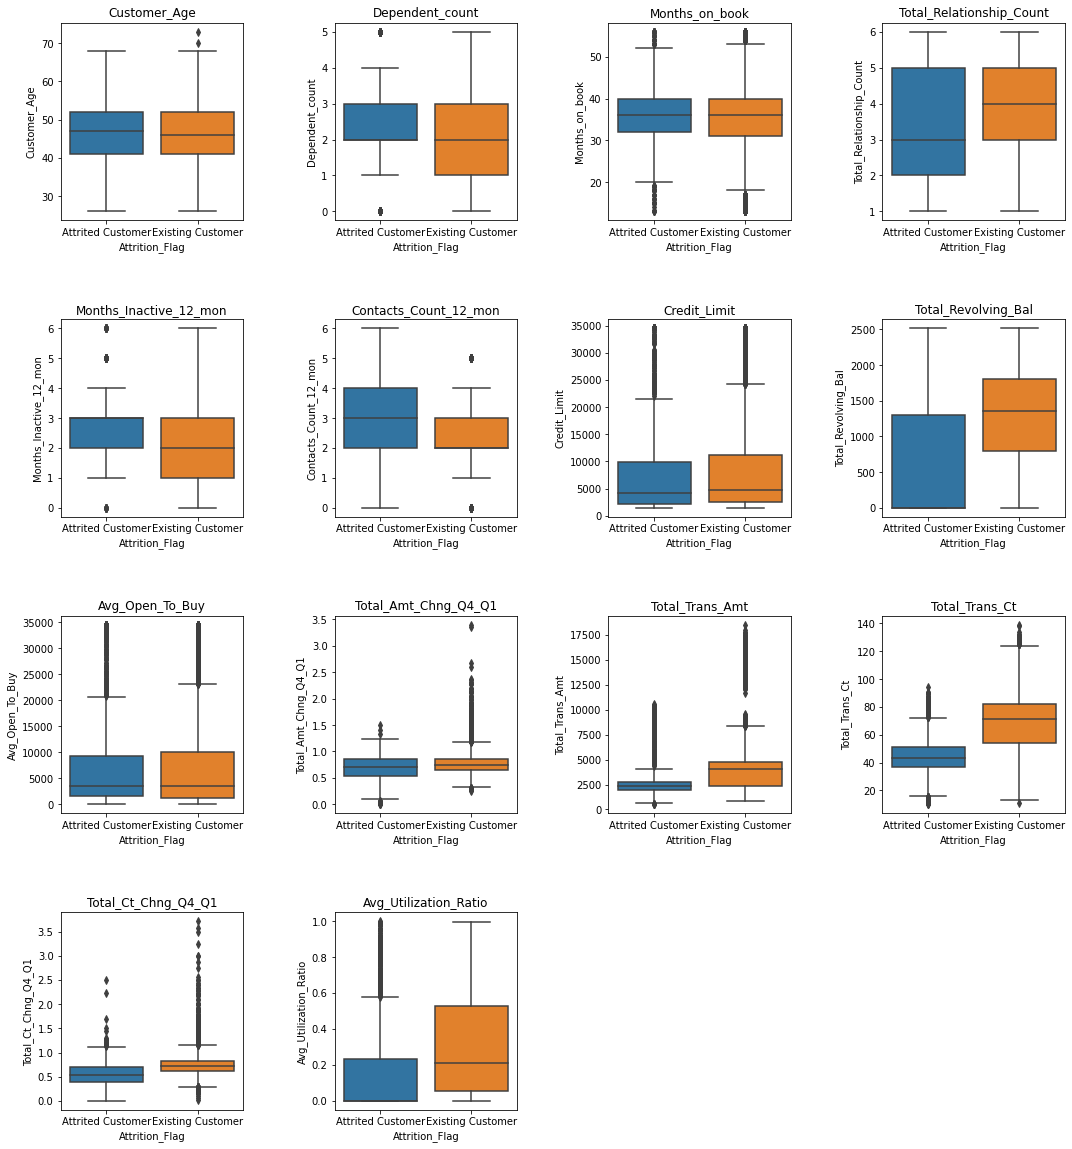

In [14]:
# we do not see any extreme outliers here
# Inspect: every column, except Customer_Age, Total_Relationship_Count,Total_Revolving_Bal
# we will try next after predicting on raw data:
# 1) IQR adjusting
# 2) PowerTransformer to make the data more normal and less skewed
# 3) IterativeImputer to impute possible outliers, detected by IQR
# NOTE: also good techniques for outlier detection are IsolationForest, DBSCAN, 
# dimensionality reduction methods

plt.figure(figsize=(18,20))
for idx, column in enumerate(numerical_cols, 1):
    plt.subplot(4, 4, idx)
    sns.boxplot(y=df[column], x=df[TARGET_NAME], data=df)
    plt.title(f'{column}')
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

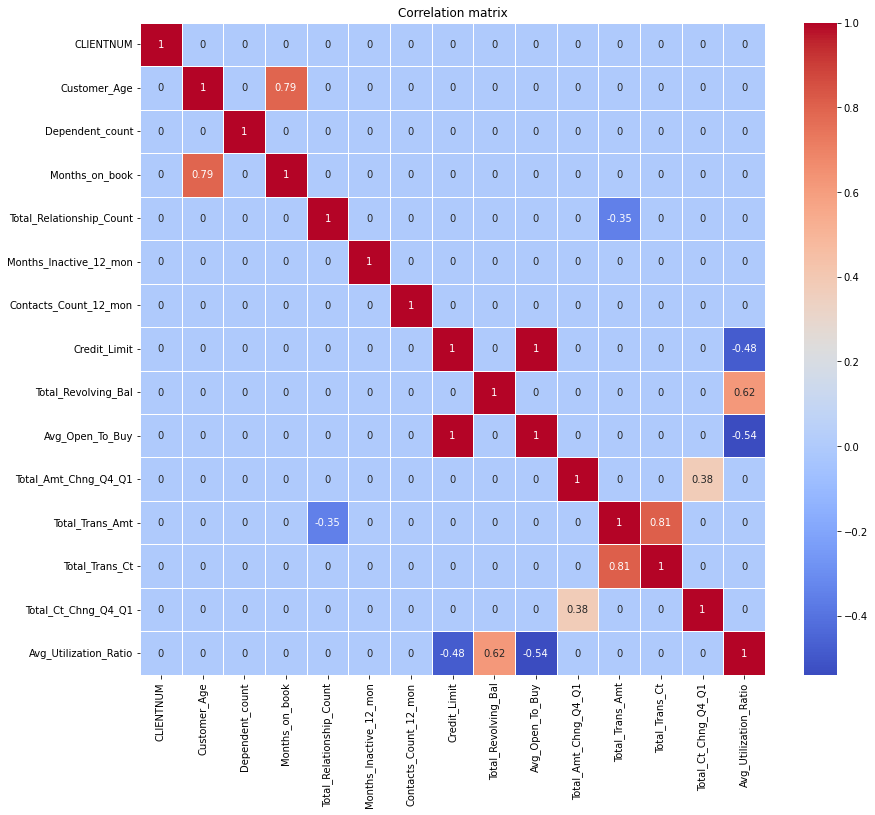

In [15]:
# let's see what linear correlations between features do we have
# we have significant correlation between Customer_Age and Months_on_book,
# Total_Trans_Amt and Total_Trans_Ct
# meddle high correlations between: Total_Revolving_Bal and Avg_Utilization_Ratio
# Avg_Open_To_Buy and Avg_Utilization_Ratio
# looks like the author created a few variables using groupby and count, averaging 
# methods
# As the correlations are high it might be useful to drop one of the dependent feature
# but we would rather use feature-selection methods to decide whether to drop some, 
# as otherwise we can loose meaningful information
plt.figure(figsize = (14,12))
corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

#### Let's compute some statistical tests to find out the significance of given variables

In [16]:
df[TARGET_NAME] = df[TARGET_NAME].map({'Existing Customer': 0, 'Attrited Customer': 1})
df[TARGET_NAME] = df[TARGET_NAME].astype(np.uint8)

In [24]:
# first we will check the histplot results, assuming all numerical features are useful
# we got some interesting insites! For a given significance level (0.05) and sample_size
# (5%) we can conclude that Customer_Age, Dependent_count, Months_on_book, Avg_Open_To_Buy
# have no statisticaly meaningful impact on target
# again: we will note this fact in head and later apply feature-selection to decide
statistic_output(*numerical_cols, sample_size=500)

Factor "CLIENTNUM" has statistical impact on target (var_a: 1477484812435724.00, var_b: 1581338126040330.50). 
Factor "Customer_Age" does not affect target.
Factor "Dependent_count" does not affect target.
Factor "Months_on_book" does not affect target.
Factor "Total_Relationship_Count" has statistical impact on target (var_a: 2.28, var_b: 2.40). 
Factor "Months_Inactive_12_mon" has statistical impact on target (var_a: 1.06, var_b: 0.75). 
Factor "Contacts_Count_12_mon" has statistical impact on target (var_a: 1.21, var_b: 1.33). 
Factor "Credit_Limit" does not affect target.
Factor "Total_Revolving_Bal" has statistical impact on target (var_a: 592974.68, var_b: 647707.11). 
Factor "Avg_Open_To_Buy" does not affect target.
Factor "Total_Amt_Chng_Q4_Q1" has statistical impact on target (var_a: 0.03, var_b: 0.04). 
Factor "Total_Trans_Amt" has statistical impact on target (var_a: 12219797.20, var_b: 4473731.23). 
Factor "Total_Trans_Ct" has statistical impact on target (var_a: 529.85, va

In [18]:
# we use here only gender, as it is not enough category samples for such type of test
# But again we see that Gender has no impact on target as there are two equally 
# distributed categories
statistic_output('Gender', cat=True, sample_size=500)

Gender
Categories M and F can be united. P-value: 0.423509


In [19]:
# with statistic output we decide whether it is possible to union two taken categories
# here we determin if there are statistical dependency between two 
# variables (categorical feature and target)
# we got ALL statistically weak features. In the end, we cannot drop them all
# we have to make feature-selection
categorical_stats()

Gender
Education_Level
Marital_Status
Income_Category
Card_Category
Statistically weak categorical features:  Gender Education_Level Marital_Status Income_Category Card_Category


#### Complete Raw dataset and define base model

In [25]:
# set id as index as we won't use it in predictions, but also we want to 
# identify every customer later
df.set_index('CLIENTNUM', drop=True, inplace=True)
df.head(1)

Attrition_Flag  Customer_Age Gender  Dependent_count  \
CLIENTNUM                                                         
768805383               0            45      M                3   

          Education_Level Marital_Status Income_Category Card_Category  \
CLIENTNUM                                                                
768805383     High School        Married     $60K - $80K          Blue   

           Months_on_book  Total_Relationship_Count  Months_Inactive_12_mon  \
CLIENTNUM                                                                     
768805383              39                         5                       1   

           Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
CLIENTNUM                                                             
768805383                      3       12691.0                  777   

           Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  \
CLIENTNUM                                                           
768805383          11914.0                 1.335             1144   

           Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
CLIENTNUM                                                              
768805383              42                1.625                  0.061

In [26]:
# just mapping binary caterories and changing the correct dtype
df['Gender'] = df['Gender'].map({'M': 0, 'F': 1})
df['Gender'] = df['Gender'].astype(np.uint8)

In [27]:
# getting all model parameters as default
base = LGBMClassifier(verbose=-1)

#### Search of the best split

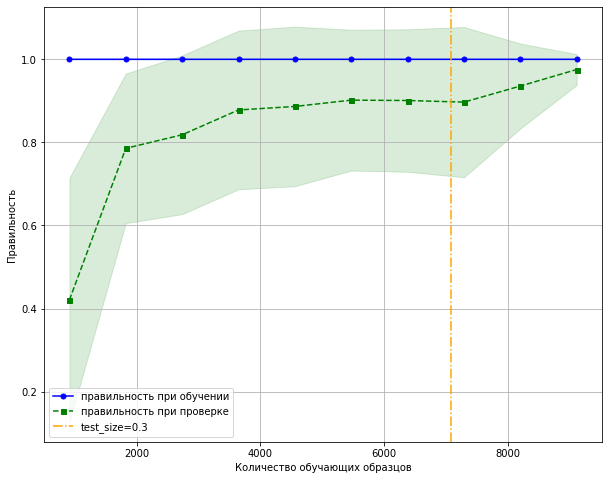

In [28]:
X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]

train_sizes, train_scores, test_scores = learning_curve(estimator=base, X=X, y=y, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), cv=10, scoring='roc_auc', n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 8))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='правильность при обучении')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='правильность при проверке')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.axvline(X.shape[0]*0.7, color='orange', linestyle='-.', label='test_size=0.3')
plt.grid()
plt.xlabel('Количество обучающих образцов')
plt.ylabel('Правильность')
plt.legend(loc='best')
plt.show()
# setting test_size=0.3 looks fine, but in case of validation data we will set
# test_size=0.25, valid_size=0.15

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train, random_state=123)
print(f'Train size: {X_train.shape[0]}, Validation size: {X_valid.shape[0]}, Test size: {X_test.shape[0]}')

Train size: 7290, Validation size: 811, Test size: 2026


#### Dealing with outliers

In [30]:
# raw predictions
base.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False, early_stopping_rounds=5, eval_metric='roc_auc')
base_raw_train = base.predict(X_train)
base_raw_test = base.predict(X_test)
base_train_proba = base.predict_proba(X_train)[:,1]
base_test_proba = base.predict_proba(X_test)[:,1]

report(y_train, base_raw_train, y_test, base_raw_test, base_train_proba, base_test_proba)

Train
               precision    recall  f1-score   support

           0      0.998     0.998     0.998      6118
           1      0.991     0.991     0.991      1172

    accuracy                          0.997      7290
   macro avg      0.994     0.995     0.995      7290
weighted avg      0.997     0.997     0.997      7290

Test
               precision    recall  f1-score   support

           0      0.977     0.991     0.984      1701
           1      0.947     0.877     0.911       325

    accuracy                          0.972      2026
   macro avg      0.962     0.934     0.947      2026
weighted avg      0.972     0.972     0.972      2026

Train ROC_AUC: 1.000, Test ROC_AUC: 0.995
Confusion Matrix 
 col_0              0    1
Attrition_Flag           
0               1685   16
1                 40  285


In [31]:
columns_with_outliers = ['Dependent_count','Months_on_book', 'Months_Inactive_12_mon',
                         'Contacts_Count_12_mon', 'Credit_Limit', 'Avg_Open_To_Buy',
                         'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct',
                         'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

In [32]:
# IQR adjusting
for column in columns_with_outliers:
    q1 = np.quantile(X_train[column], 0.25)
    q3 = np.quantile(X_train[column], 0.75)
    iq_low = q1 - 1.5 * (q3 - q1)
    iq_high = q3 + 1.5 * (q3 - q1)
    X_train.loc[X_train[column] > iq_high, column] = iq_high
    X_train.loc[X_train[column] < iq_low, column] = iq_low
    
    X_valid.loc[X_valid[column] > iq_high, column] = iq_high
    X_valid.loc[X_valid[column] < iq_low, column] = iq_low
    
    X_test.loc[X_test[column] > iq_high, column] = iq_high
    X_test.loc[X_test[column] < iq_low, column] = iq_low

In [33]:
base.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False, early_stopping_rounds=5, eval_metric='roc_auc')
base_iqr_train = base.predict(X_train)
base_iqr_test = base.predict(X_test)
base_train_proba = base.predict_proba(X_train)[:,1]
base_test_proba = base.predict_proba(X_test)[:,1]

report(y_train, base_iqr_train, y_test, base_iqr_test, base_train_proba, base_test_proba)
# actually we cannot see any meaningful difference. Thus FN is higher than in raw-case
# We assume that it is better to leave less FN

Train
               precision    recall  f1-score   support

           0      0.999     0.999     0.999      6118
           1      0.993     0.994     0.994      1172

    accuracy                          0.998      7290
   macro avg      0.996     0.996     0.996      7290
weighted avg      0.998     0.998     0.998      7290

Test
               precision    recall  f1-score   support

           0      0.976     0.991     0.983      1701
           1      0.950     0.871     0.909       325

    accuracy                          0.972      2026
   macro avg      0.963     0.931     0.946      2026
weighted avg      0.972     0.972     0.971      2026

Train ROC_AUC: 1.000, Test ROC_AUC: 0.995
Confusion Matrix 
 col_0              0    1
Attrition_Flag           
0               1686   15
1                 42  283


#### Power Transformer

In [40]:
df = pd.read_csv(data_root) # read
df = df.iloc[:, :-2] # remove redundant columns
df.drop_duplicates(inplace=True) # drop duplicates
df = reduce_memory(df, verbose=0) # reduce memory
df[TARGET_NAME] = df[TARGET_NAME].map({'Existing Customer': 0, 'Attrited Customer': 1}) # map target
df[TARGET_NAME] = df[TARGET_NAME].astype(np.uint8)
df.set_index('CLIENTNUM', drop=True, inplace=True) # set client id as index
df = pd.get_dummies(df, prefix=['col1', 'col2', 'col3', 'col4', 'col5'], drop_first=True)

X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train, random_state=123)
print(f'Train size: {X_train.shape[0]}, Validation size: {X_valid.shape[0]}, Test size: {X_test.shape[0]}')

Train size: 7290, Validation size: 811, Test size: 2026


In [41]:
# Transformation to normal distribution
column_transformer = ColumnTransformer(transformers=[
    ('power', PowerTransformer(), columns_with_outliers)
], remainder='passthrough')

X_train = column_transformer.fit_transform(X_train, y_train)
X_valid = column_transformer.transform(X_valid)
X_test = column_transformer.transform(X_test)

In [42]:
base.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False, early_stopping_rounds=5, eval_metric='roc_auc')
base_pow_train = base.predict(X_train)
base_pow_test = base.predict(X_test)
base_train_proba = base.predict_proba(X_train)[:,1]
base_test_proba = base.predict_proba(X_test)[:,1]

report(y_train, base_pow_train, y_test, base_pow_test, base_train_proba, base_test_proba)
# as excpected normal-transformation method does not fit this particular situation

Train
               precision    recall  f1-score   support

           0      0.984     0.992     0.988      6118
           1      0.957     0.917     0.937      1172

    accuracy                          0.980      7290
   macro avg      0.971     0.955     0.963      7290
weighted avg      0.980     0.980     0.980      7290

Test
               precision    recall  f1-score   support

           0      0.950     0.979     0.965      1701
           1      0.872     0.732     0.796       325

    accuracy                          0.940      2026
   macro avg      0.911     0.856     0.880      2026
weighted avg      0.938     0.940     0.938      2026

Train ROC_AUC: 0.997, Test ROC_AUC: 0.973
Confusion Matrix 
 col_0              0    1
Attrition_Flag           
0               1666   35
1                 87  238


### IterativeImputer

In [43]:
df = pd.read_csv(data_root) # read
df = df.iloc[:, :-2] # remove redundant columns
df.drop_duplicates(inplace=True) # drop duplicates
df = reduce_memory(df, verbose=0) # reduce memory
df[TARGET_NAME] = df[TARGET_NAME].map({'Existing Customer': 0, 'Attrited Customer': 1}) # map target
df[TARGET_NAME] = df[TARGET_NAME].astype(np.uint8)
df.set_index('CLIENTNUM', drop=True, inplace=True) # set client id as index
df = pd.get_dummies(df, prefix=['col1', 'col2', 'col3', 'col4', 'col5'], drop_first=True)

X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train, random_state=123)
print(f'Train size: {X_train.shape[0]}, Validation size: {X_valid.shape[0]}, Test size: {X_test.shape[0]}')

Train size: 7290, Validation size: 811, Test size: 2026


In [44]:
# Imputation
for column in columns_with_outliers:
    q1 = np.quantile(X_train[column], 0.25)
    q3 = np.quantile(X_train[column], 0.75)
    iq_low = q1 - 1.5 * (q3 - q1)
    iq_high = q3 + 1.5 * (q3 - q1)
    X_train.loc[X_train[column] > iq_high, column] = None
    X_train.loc[X_train[column] < iq_low, column] = None
    
    X_valid.loc[X_valid[column] > iq_high, column] = None
    X_valid.loc[X_valid[column] < iq_low, column] = None
    
    X_test.loc[X_test[column] > iq_high, column] = None
    X_test.loc[X_test[column] < iq_low, column] = None

In [45]:
from sklearn.linear_model import LinearRegression

imputer = IterativeImputer(estimator=LinearRegression(), random_state=123)
X_train = imputer.fit_transform(X_train)
X_valid = imputer.transform(X_valid)
X_test = imputer.transform(X_test)

In [46]:
base.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False, early_stopping_rounds=5, eval_metric='roc_auc')
base_imp_train = base.predict(X_train)
base_imp_test = base.predict(X_test)
base_train_proba = base.predict_proba(X_train)[:,1]
base_test_proba = base.predict_proba(X_test)[:,1]

report(y_train, base_imp_train, y_test, base_imp_test, base_train_proba, base_test_proba)

Train
               precision    recall  f1-score   support

           0      0.990     0.997     0.993      6118
           1      0.981     0.948     0.964      1172

    accuracy                          0.989      7290
   macro avg      0.986     0.972     0.979      7290
weighted avg      0.989     0.989     0.989      7290

Test
               precision    recall  f1-score   support

           0      0.964     0.988     0.976      1701
           1      0.926     0.809     0.864       325

    accuracy                          0.959      2026
   macro avg      0.945     0.898     0.920      2026
weighted avg      0.958     0.959     0.958      2026

Train ROC_AUC: 0.999, Test ROC_AUC: 0.988
Confusion Matrix 
 col_0              0    1
Attrition_Flag           
0               1680   21
1                 62  263


##### Also we may just drop outliers, but as if they are not so extreme, we may loose important information

### Feature Engineering
#### We are using no more features, as there are a lot of counts and some kind of synthetic features
Grouping by categories with averaging functions and counting is good practice for boosting models.
Linear transform is good for Linear models: LogisticRegression, LinearSVM, etc.

In [49]:
df = pd.read_csv(data_root) # read
df = df.iloc[:, :-2] # remove redundant columns
df.drop_duplicates(inplace=True) # drop duplicates
df = reduce_memory(df, verbose=0) # reduce memory
df[TARGET_NAME] = df[TARGET_NAME].map({'Existing Customer': 0, 'Attrited Customer': 1}) # map target
df[TARGET_NAME] = df[TARGET_NAME].astype(np.uint8)
df.set_index('CLIENTNUM', drop=True, inplace=True) # set client id as index
df = pd.get_dummies(df, prefix=['col1', 'col2', 'col3', 'col4', 'col5'], drop_first=True)

X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]

X['Age_Cut'] = pd.cut(X['Customer_Age'], [15,25,35,45,65,90], labels=[1,2,3,4,5]).astype(np.uint8)
X['Total_Trans_Amt_Cut'] = pd.cut(X['Total_Trans_Amt'], [-1, 11e3, 100e3], labels=[0,1]).astype(np.uint8)
X['Total_Ct_Chng_Q4_Q1_Cut'] = pd.cut(X['Total_Ct_Chng_Q4_Q1'], [-1, 1, 10], labels=[0,1]).astype(np.uint8)
X['Total_Trans_Ct_Cut'] = pd.cut(X['Total_Trans_Ct'], [-1, 61, 1000], labels=[0,1]).astype(np.uint8)
X['Total_Amt_Chng_Q4_Q1_Cut'] = pd.cut(X['Total_Amt_Chng_Q4_Q1'], [-1,1,10], labels=[0,1]).astype(np.uint8)
X['Avg_Utilization_Ratio_Cut'] = pd.cut(X['Avg_Utilization_Ratio'], [-1, 0.15, 10], labels=[0,1]).astype(np.uint8)
X['Contacts_Count_12_mon_Cut'] = pd.cut(X['Contacts_Count_12_mon'], [-1,3,1000], labels=[0,1]).astype(np.uint8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train, random_state=123)
print(f'Train size: {X_train.shape}, Validation size: {X_valid.shape}, Test size: {X_test.shape}')

Train size: (7290, 39), Validation size: (811, 39), Test size: (2026, 39)


In [50]:
# base with balancing and new features
base = LGBMClassifier(verbose=-1, is_unbalance=True)
base.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False, early_stopping_rounds=5, eval_metric='roc_auc')
base_raw_train = base.predict(X_train)
base_raw_test = base.predict(X_test)
base_train_proba = base.predict_proba(X_train)[:,1]
base_test_proba = base.predict_proba(X_test)[:,1]

report(y_train, base_raw_train, y_test, base_raw_test, base_train_proba, base_test_proba)

Train
               precision    recall  f1-score   support

           0      1.000     0.992     0.996      6118
           1      0.961     1.000     0.980      1172

    accuracy                          0.994      7290
   macro avg      0.981     0.996     0.988      7290
weighted avg      0.994     0.994     0.994      7290

Test
               precision    recall  f1-score   support

           0      0.986     0.978     0.982      1701
           1      0.891     0.929     0.910       325

    accuracy                          0.970      2026
   macro avg      0.939     0.954     0.946      2026
weighted avg      0.971     0.970     0.971      2026

Train ROC_AUC: 1.000, Test ROC_AUC: 0.995
Confusion Matrix 
 col_0              0    1
Attrition_Flag           
0               1664   37
1                 23  302


#### Feature Selection

Feature Selection will have two different methods after predicting on raw data:
1) A class that selects the best subset of features, according to the given score, 
straightforward method, only computationaly reasonable for not large datasets

2) BorutaShap object, that will select features to remove: uses statistical tests and
shap values with given model (estimator)
we will compare the EDA results with this approach

In [51]:
class BestSet(BaseEstimator, TransformerMixin):
    def __init__(self, k_features=12, scoring=f1_score, test_size=0.2):
        self.scoring = scoring
        self.k_features = k_features
        self.test_size = test_size

    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y, 
                                                            test_size=self.test_size, 
                                                            stratify=y,
                                                            random_state=1)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores, subsets = [], []
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self
    def transform(self, X):
        best_indices = self.subsets_[np.argmax(self.scores_)]
        return X[:, best_indices]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        model = LGBMClassifier(boosting_type='goss',
                               is_unbalance=True,
                               max_depth=3,
                               verbose=-1,
                               random_state=1)
        model.fit(X_train[:, indices], y_train, verbose=False)
        y_pred = model.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [52]:
pipe = Pipeline(steps=[
    ('selector', BestSet(k_features=25, scoring=roc_auc_score)),
    ('base_model', LGBMClassifier(verbose=-1))
])
fit_params = {'base_model__verbose': False}

pipe.fit(X_train.values, y_train, **fit_params)
pipe_train = pipe.predict(X_train.values)
pipe_test = pipe.predict(X_test.values)
pipe_train_proba = pipe.predict_proba(X_train.values)[:,1]
pipe_test_proba = pipe.predict_proba(X_test.values)[:,1]

report(y_train, pipe_train, y_test, pipe_test, pipe_train_proba, pipe_test_proba)
# we got a tiny improve in FN

Train
               precision    recall  f1-score   support

           0      1.000     1.000     1.000      6118
           1      1.000     1.000     1.000      1172

    accuracy                          1.000      7290
   macro avg      1.000     1.000     1.000      7290
weighted avg      1.000     1.000     1.000      7290

Test
               precision    recall  f1-score   support

           0      0.976     0.988     0.982      1701
           1      0.934     0.874     0.903       325

    accuracy                          0.970      2026
   macro avg      0.955     0.931     0.943      2026
weighted avg      0.969     0.970     0.969      2026

Train ROC_AUC: 1.000, Test ROC_AUC: 0.995
Confusion Matrix 
 col_0              0    1
Attrition_Flag           
0               1681   20
1                 41  284


In [53]:
indices = pipe[0].subsets_[np.argmax(pipe[0].scores_)]
print(f'Remain columns: {len(indices)}')
# dropped 4 features
X.iloc[0, list(indices)]
# it is curious as Gender feature was not dropped

Remain columns: 37


Customer_Age                    45.000
Dependent_count                  3.000
Months_on_book                  39.000
Total_Relationship_Count         5.000
Months_Inactive_12_mon           1.000
Contacts_Count_12_mon            3.000
Credit_Limit                 12691.000
Total_Revolving_Bal            777.000
Avg_Open_To_Buy              11914.000
Total_Amt_Chng_Q4_Q1             1.335
Total_Trans_Amt               1144.000
Total_Trans_Ct                  42.000
Total_Ct_Chng_Q4_Q1              1.625
Avg_Utilization_Ratio            0.061
col1_M                           1.000
col2_Doctorate                   0.000
col2_Graduate                    0.000
col2_High School                 1.000
col2_Post-Graduate               0.000
col2_Uneducated                  0.000
col2_Unknown                     0.000
col3_Married                     1.000
col3_Single                      0.000
col3_Unknown                     0.000
col4_$40K - $60K                 0.000
col4_$80K - $120K        

In [54]:
# borutaShap
selector = BorutaShap(model=LGBMClassifier(verbose=-1, is_unbalance=True), importance_measure='shap', classification=True)
selector.fit(X_train, y_train, n_trials=50, sample=False, verbose=False)

  0%|          | 0/50 [00:00<?, ?it/s]

In [55]:
selector.features_to_remove

array(['Dependent_count', 'Months_on_book', 'Avg_Utilization_Ratio',
       'col1_M', 'col2_Doctorate', 'col2_Graduate', 'col2_High School',
       'col2_Post-Graduate', 'col2_Uneducated', 'col2_Unknown',
       'col3_Married', 'col3_Single', 'col3_Unknown', 'col4_$40K - $60K',
       'col4_$60K - $80K', 'col4_$80K - $120K', 'col4_Less than $40K',
       'col4_Unknown', 'col5_Gold', 'col5_Platinum', 'col5_Silver',
       'Age_Cut', 'Total_Ct_Chng_Q4_Q1_Cut', 'Total_Trans_Ct_Cut',
       'Total_Amt_Chng_Q4_Q1_Cut', 'Avg_Utilization_Ratio_Cut',
       'Contacts_Count_12_mon_Cut'], dtype=object)

In [56]:
X_train.drop(selector.features_to_remove.tolist(), axis=1, inplace=True)
X_valid.drop(selector.features_to_remove.tolist(), axis=1, inplace=True)
X_test.drop(selector.features_to_remove.tolist(), axis=1, inplace=True)

In [57]:
base.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False, early_stopping_rounds=5, eval_metric='roc_auc')
base_bor_train = base.predict(X_train)
base_bor_test = base.predict(X_test)
base_train_proba = base.predict_proba(X_train)[:,1]
base_test_proba = base.predict_proba(X_test)[:,1]

report(y_train, base_bor_train, y_test, base_bor_test, base_train_proba, base_test_proba)
# after dropping we got almost the same confusion matrix but model overfits more
# if it was large dataset it would be the best choice in computational order and in order
# to reduce the job for scrapping the data.
# So we will use BestSet with lgbm and raw data with CatBoostClassifier

Train
               precision    recall  f1-score   support

           0      1.000     0.993     0.997      6118
           1      0.965     1.000     0.982      1172

    accuracy                          0.994      7290
   macro avg      0.983     0.997     0.989      7290
weighted avg      0.994     0.994     0.994      7290

Test
               precision    recall  f1-score   support

           0      0.986     0.979     0.982      1701
           1      0.893     0.926     0.909       325

    accuracy                          0.970      2026
   macro avg      0.939     0.952     0.946      2026
weighted avg      0.971     0.970     0.971      2026

Train ROC_AUC: 1.000, Test ROC_AUC: 0.995
Confusion Matrix 
 col_0              0    1
Attrition_Flag           
0               1665   36
1                 24  301


#### sklearn selector, based on feature imporatnce obtained from fitted model

In [77]:
df = pd.read_csv(data_root) # read
df = df.iloc[:, :-2] # remove redundant columns
df.drop_duplicates(inplace=True) # drop duplicates
df = reduce_memory(df, verbose=0) # reduce memory
df[TARGET_NAME] = df[TARGET_NAME].map({'Existing Customer': 0, 'Attrited Customer': 1}) # map target
df[TARGET_NAME] = df[TARGET_NAME].astype(np.uint8)
df.set_index('CLIENTNUM', drop=True, inplace=True) # set client id as index
df = pd.get_dummies(df, prefix=['col1', 'col2', 'col3', 'col4', 'col5'], drop_first=True)

X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]

X['Age_Cut'] = pd.cut(X['Customer_Age'], [15,25,35,45,65,90], labels=[1,2,3,4,5]).astype(np.uint8)
X['Total_Trans_Amt_Cut'] = pd.cut(X['Total_Trans_Amt'], [-1, 11e3, 100e3], labels=[0,1]).astype(np.uint8)
X['Total_Ct_Chng_Q4_Q1_Cut'] = pd.cut(X['Total_Ct_Chng_Q4_Q1'], [-1, 1, 10], labels=[0,1]).astype(np.uint8)
X['Total_Trans_Ct_Cut'] = pd.cut(X['Total_Trans_Ct'], [-1, 61, 1000], labels=[0,1]).astype(np.uint8)
X['Total_Amt_Chng_Q4_Q1_Cut'] = pd.cut(X['Total_Amt_Chng_Q4_Q1'], [-1,1,10], labels=[0,1]).astype(np.uint8)
X['Avg_Utilization_Ratio_Cut'] = pd.cut(X['Avg_Utilization_Ratio'], [-1, 0.15, 10], labels=[0,1]).astype(np.uint8)
X['Contacts_Count_12_mon_Cut'] = pd.cut(X['Contacts_Count_12_mon'], [-1,3,1000], labels=[0,1]).astype(np.uint8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train, random_state=123)
print(f'Train size: {X_train.shape}, Validation size: {X_valid.shape}, Test size: {X_test.shape}')

Train size: (7290, 39), Validation size: (811, 39), Test size: (2026, 39)


In [75]:
from sklearn.feature_selection import SelectFromModel
# reset datasets first
base.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False, early_stopping_rounds=5, eval_metric='roc_auc')

from_model = SelectFromModel(estimator=base,
                             max_features=25,
                             prefit=False,
                             ).fit(X_train, y_train)

feature_names_enc = from_model.get_feature_names_out()
X_train, X_test, X_valid = X_train.loc[:, feature_names_enc], X_test.loc[:, feature_names_enc], X_valid.loc[:,feature_names_enc]

base.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False, early_stopping_rounds=5, eval_metric='roc_auc')
base_mod_train = base.predict(X_train)
base_mod_test = base.predict(X_test)
base_train_proba = base.predict_proba(X_train)[:,1]
base_test_proba = base.predict_proba(X_test)[:,1]

report(y_train, base_mod_train, y_test, base_mod_test, base_train_proba, base_test_proba)
# here is the best way found

Train
               precision    recall  f1-score   support

           0      1.000     0.995     0.997      6118
           1      0.974     1.000     0.987      1172

    accuracy                          0.996      7290
   macro avg      0.987     0.997     0.992      7290
weighted avg      0.996     0.996     0.996      7290

Test
               precision    recall  f1-score   support

           0      0.987     0.981     0.984      1701
           1      0.904     0.932     0.918       325

    accuracy                          0.973      2026
   macro avg      0.946     0.957     0.951      2026
weighted avg      0.974     0.973     0.974      2026

Train ROC_AUC: 1.000, Test ROC_AUC: 0.995
Confusion Matrix 
 col_0              0    1
Attrition_Flag           
0               1669   32
1                 22  303


In [78]:
from sklearn.feature_selection import SelectFromModel

# redefine dataset first
forest = ExtraTreesClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_leaf=1, 
                              min_weight_fraction_leaf=0., max_features='auto', bootstrap=True, random_state=123, n_jobs=-1,
                              class_weight='balanced', ccp_alpha=0., max_samples=None).fit(X_train, y_train)

from_model = SelectFromModel(estimator=forest,
                             max_features=25,
                             prefit=False,
                             ).fit(X_train, y_train)

feature_names_enc = from_model.get_feature_names_out().tolist()
X_train, X_test, X_valid = X_train.loc[:, feature_names_enc], X_test.loc[:, feature_names_enc], X_valid.loc[:,feature_names_enc]

forest.fit(X_train, y_train)
base_mod_train = forest.predict(X_train)
base_mod_test = forest.predict(X_test)
base_train_proba = forest.predict_proba(X_train)[:,1]
base_test_proba = forest.predict_proba(X_test)[:,1]

report(y_train, base_mod_train, y_test, base_mod_test, base_train_proba, base_test_proba)

Train
               precision    recall  f1-score   support

           0      1.000     1.000     1.000      6118
           1      1.000     1.000     1.000      1172

    accuracy                          1.000      7290
   macro avg      1.000     1.000     1.000      7290
weighted avg      1.000     1.000     1.000      7290

Test
               precision    recall  f1-score   support

           0      0.948     0.989     0.968      1701
           1      0.925     0.717     0.808       325

    accuracy                          0.945      2026
   macro avg      0.936     0.853     0.888      2026
weighted avg      0.944     0.945     0.942      2026

Train ROC_AUC: 1.000, Test ROC_AUC: 0.986
Confusion Matrix 
 col_0              0    1
Attrition_Flag           
0               1682   19
1                 92  233


#### SMOTE and class weighting

In [85]:
df = pd.read_csv(data_root) # read
df = df.iloc[:, :-2] # remove redundant columns
df.drop_duplicates(inplace=True) # drop duplicates
df = reduce_memory(df, verbose=0) # reduce memory
df[TARGET_NAME] = df[TARGET_NAME].map({'Existing Customer': 0, 'Attrited Customer': 1}) # map target
df[TARGET_NAME] = df[TARGET_NAME].astype(np.uint8)
df.set_index('CLIENTNUM', drop=True, inplace=True) # set client id as index
df = pd.get_dummies(df, prefix=['col1', 'col2', 'col3', 'col4', 'col5'], drop_first=True)

X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]

X['Age_Cut'] = pd.cut(X['Customer_Age'], [15,25,35,45,65,90], labels=[1,2,3,4,5]).astype(np.uint8)
X['Total_Trans_Amt_Cut'] = pd.cut(X['Total_Trans_Amt'], [-1, 11e3, 100e3], labels=[0,1]).astype(np.uint8)
X['Total_Ct_Chng_Q4_Q1_Cut'] = pd.cut(X['Total_Ct_Chng_Q4_Q1'], [-1, 1, 10], labels=[0,1]).astype(np.uint8)
X['Total_Trans_Ct_Cut'] = pd.cut(X['Total_Trans_Ct'], [-1, 61, 1000], labels=[0,1]).astype(np.uint8)
X['Total_Amt_Chng_Q4_Q1_Cut'] = pd.cut(X['Total_Amt_Chng_Q4_Q1'], [-1,1,10], labels=[0,1]).astype(np.uint8)
X['Avg_Utilization_Ratio_Cut'] = pd.cut(X['Avg_Utilization_Ratio'], [-1, 0.15, 10], labels=[0,1]).astype(np.uint8)
X['Contacts_Count_12_mon_Cut'] = pd.cut(X['Contacts_Count_12_mon'], [-1,3,1000], labels=[0,1]).astype(np.uint8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train, random_state=123)
print(f'Train size: {X_train.shape}, Validation size: {X_valid.shape}, Test size: {X_test.shape}')

Train size: (7290, 39), Validation size: (811, 39), Test size: (2026, 39)


In [87]:
# class weights balancing
pipe = Pipeline(steps=[
    ('selector', BestSet(k_features=30, scoring=roc_auc_score)),
    ('base_model', LGBMClassifier(is_unbalance=True, verbose=-1))
])
fit_params = {'base_model__verbose': False}

pipe.fit(X_train.values, y_train, **fit_params)
pipe_train = pipe.predict(X_train.values)
pipe_test = pipe.predict(X_test.values)
pipe_train_proba = pipe.predict_proba(X_train.values)[:,1]
pipe_test_proba = pipe.predict_proba(X_test.values)[:,1]

report(y_train, pipe_train, y_test, pipe_test, pipe_train_proba, pipe_test_proba)

Train
               precision    recall  f1-score   support

           0      1.000     0.997     0.999      6118
           1      0.987     1.000     0.993      1172

    accuracy                          0.998      7290
   macro avg      0.993     0.999     0.996      7290
weighted avg      0.998     0.998     0.998      7290

Test
               precision    recall  f1-score   support

           0      0.986     0.981     0.984      1701
           1      0.904     0.926     0.915       325

    accuracy                          0.972      2026
   macro avg      0.945     0.954     0.949      2026
weighted avg      0.973     0.972     0.972      2026

Train ROC_AUC: 1.000, Test ROC_AUC: 0.996
Confusion Matrix 
 col_0              0    1
Attrition_Flag           
0               1669   32
1                 24  301


In [82]:
# single SMOTE
pipe = Pipe(steps=[
    ('selector', BestSet(k_features=30, scoring=roc_auc_score)),
    ('SMOTE', SMOTEENN(sampling_strategy=1., random_state=123)),
    ('base_model', LGBMClassifier(verbose=-1))
])
fit_params = {'base_model__verbose': False}

pipe.fit(X_train.values, y_train, **fit_params)
pipe_train = pipe.predict(X_train.values)
pipe_test = pipe.predict(X_test.values)
pipe_train_proba = pipe.predict_proba(X_train.values)[:,1]
pipe_test_proba = pipe.predict_proba(X_test.values)[:,1]

report(y_train, pipe_train, y_test, pipe_test, pipe_train_proba, pipe_test_proba)

Train
               precision    recall  f1-score   support

           0      0.994     0.958     0.976      6118
           1      0.815     0.972     0.886      1172

    accuracy                          0.960      7290
   macro avg      0.905     0.965     0.931      7290
weighted avg      0.966     0.960     0.961      7290

Test
               precision    recall  f1-score   support

           0      0.983     0.952     0.967      1701
           1      0.786     0.914     0.845       325

    accuracy                          0.946      2026
   macro avg      0.884     0.933     0.906      2026
weighted avg      0.951     0.946     0.948      2026

Train ROC_AUC: 0.991, Test ROC_AUC: 0.986
Confusion Matrix 
 col_0              0    1
Attrition_Flag           
0               1620   81
1                 28  297


In [84]:
# SMOTE and class_weights
pipe = Pipe(steps=[
    ('selector', BestSet(k_features=30, scoring=roc_auc_score)),
    ('SMOTE', SMOTEENN(sampling_strategy=0.7, random_state=123)),
    ('base_model', LGBMClassifier(is_unbalance=True, verbose=-1))
])
fit_params = {'base_model__verbose': False}

pipe.fit(X_train.values, y_train, **fit_params)
pipe_train = pipe.predict(X_train.values)
pipe_test = pipe.predict(X_test.values)
pipe_train_proba = pipe.predict_proba(X_train.values)[:,1]
pipe_test_proba = pipe.predict_proba(X_test.values)[:,1]

report(y_train, pipe_train, y_test, pipe_test, pipe_train_proba, pipe_test_proba)

Train
               precision    recall  f1-score   support

           0      0.989     0.961     0.975      6118
           1      0.822     0.943     0.878      1172

    accuracy                          0.958      7290
   macro avg      0.905     0.952     0.927      7290
weighted avg      0.962     0.958     0.959      7290

Test
               precision    recall  f1-score   support

           0      0.981     0.955     0.968      1701
           1      0.794     0.902     0.844       325

    accuracy                          0.947      2026
   macro avg      0.887     0.928     0.906      2026
weighted avg      0.951     0.947     0.948      2026

Train ROC_AUC: 0.988, Test ROC_AUC: 0.984
Confusion Matrix 
 col_0              0    1
Attrition_Flag           
0               1625   76
1                 32  293


#### We will use only class_weights

### RandomForest tuning

In [88]:
# in order not to select every trial
X_train = pipe[0].fit_transform(X_train.values, y_train)
X_valid = pipe[0].transform(X_valid.values)
X_test = pipe[0].transform(X_test.values)

In [ ]:
model_params = {
    'random_state': 123,
    'n_jobs': -1,
    'bootstrap': True,
}

In [ ]:
def objective(trial):
    param_trials = {
                    'n_estimators': trial.suggest_int('n_estimators', 40, 500),
                    'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
                    'max_depth': trial.suggest_int('max_depth', 3, 12),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 31),
                    'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 0., .5),
                    'max_features': trial.suggest_categorical('max_features', ['auto', 'log2', 'sqrt', None]),
                    'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None]),
                    'ccp_alpha': trial.suggest_float('ccp_alpha', 0., 3.),
                    'max_samples': trial.suggest_float('max_samples', 0., 1.)
        
                    }
    param_trials.update(model_params)
    opt_model = ExtraTreesClassifier(**param_trials)
    opt_model.fit(X_train, y_train)
    
    y_pred = opt_model.predict_proba(X_valid)[:,1]
    score = roc_auc_score(y_valid, y_pred)
    
    return score

In [ ]:
optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(sampler=TPESampler(seed=123), direction="maximize")
study.optimize(objective, n_trials=100, timeout=6000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
for key, value in trial.params.items():
    print(f'{key}: {value}')

In [86]:
model_params = {
                'random_state': 123,
                'n_jobs': -1,
                'bootstrap': True,
                'n_estimators': 474,
                'criterion': 'entropy',
                'max_depth': 11,
                'min_samples_leaf': 6,
                'min_weight_fraction_leaf': 0.0001030771385651417,
                'max_features': None,
                'class_weight': None,
                'ccp_alpha': 0.00015779217602960162,
                'max_samples': 0.7702521519579486,
}

In [89]:
# predict on forest
forest = ExtraTreesClassifier(**model_params)
forest.fit(X_train, y_train)
base_mod_train = forest.predict(X_train)
base_mod_test = forest.predict(X_test)
base_train_proba = forest.predict_proba(X_train)[:,1]
base_test_proba = forest.predict_proba(X_test)[:,1]

report(y_train, base_mod_train, y_test, base_mod_test, base_train_proba, base_test_proba)

Train
               precision    recall  f1-score   support

           0      0.968     0.986     0.977      6118
           1      0.920     0.829     0.872      1172

    accuracy                          0.961      7290
   macro avg      0.944     0.908     0.925      7290
weighted avg      0.960     0.961     0.960      7290

Test
               precision    recall  f1-score   support

           0      0.947     0.982     0.965      1701
           1      0.885     0.714     0.790       325

    accuracy                          0.939      2026
   macro avg      0.916     0.848     0.877      2026
weighted avg      0.937     0.939     0.937      2026

Train ROC_AUC: 0.992, Test ROC_AUC: 0.979
Confusion Matrix 
 col_0              0    1
Attrition_Flag           
0               1671   30
1                 93  232


### LGBM Hyperparameter tuning

In [90]:
model_params = {
                'objective': 'binary', # cross_entropy
                'n_estimators': 800,
                'n_jobs': -1,
                'is_unbalance': True,
                'random_state': 123
}
fit_params = {'early_stopping_rounds': 10,  
              'eval_set': [(X_valid, y_valid)],  
              'eval_metric': 'auc',
              'verbose': False
}

In [91]:
def objective(trial):
    param_trials = {
                    'max_depth': trial.suggest_int('max_depth', 3, 9),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
                    'reg_alpha': trial.suggest_float('reg_alpha', 1., 5.),
                    'reg_lambda': trial.suggest_float('reg_lambda', 1., 5.),
                    'num_leaves': trial.suggest_int('num_leaves', 20, 265),
                    'subsample': trial.suggest_float('subsample', 0.3, 1.),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.),
                    'max_bin': trial.suggest_int('max_bin', 60, 260),
                    'min_child_samples': trial.suggest_int('min_child_samples', 120, 260),
                    'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 0.1),
                    'boosting_type': trial.suggest_categorical('boosting_type', ['goss', 'gbdt']),
                    }
    param_trials.update(model_params)
    opt_model = LGBMClassifier(**param_trials)
    opt_model.fit(X_train, y_train, **fit_params)
    
    y_pred = opt_model.predict_proba(X_valid)[:,1]
    score = roc_auc_score(y_valid, y_pred)
    
    return score

In [ ]:
optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(sampler=TPESampler(seed=123), direction="maximize")
study.optimize(objective, n_trials=500, timeout=6000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
for key, value in trial.params.items():
    print(f'{key}: {value}')

### LGBM stratified predcitions

In [93]:
# features selected by BestSet
model_params = {
                'objective': 'binary',
                'n_estimators': 800,
                'n_jobs': -1,
                'is_unbalance': True,
                'random_state': 123,
                'max_depth': 8,
                'learning_rate': 0.06334858903177704, # 0.16334858903177704
                'reg_alpha': 1.7581994842893593,
                'reg_lambda': 4.962605889056071,
                'num_leaves': 144,
                'subsample': 0.35154539457722855,
                'colsample_bytree': 0.5436963612580455, # 0.6436963612580455
                'max_bin': 219,
                'min_child_samples': 124,
                'min_child_weight': 0.02483278328435734,
                'boosting_type': 'gbdt',
}
fit_params = {'early_stopping_rounds': 10,  
              'eval_set': [(X_valid, y_valid)],  
              'eval_metric': 'auc',
              'verbose': False
}

In [94]:
# save index
# BestSet
indices = pipe[0].subsets_[np.argmax(pipe[0].scores_)]
X_index = X.index
X_ = X.values[:, indices]
X_fold, X_test, y_fold, y_test = train_test_split(X_, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)
print(f'Train size: {X_fold.shape[0]}, Test size: {X_test.shape[0]}')

Train size: 8101, Test size: 2026


In [ ]:
# Selected by feature importances
X_ = X.values[:, feature_names_enc]
X_fold, X_test, y_fold, y_test = train_test_split(X_, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)
print(f'Train size: {X_fold.shape}, Test size: {X_test.shape}')

In [95]:
model_params = {
                'objective': 'binary',
                'n_estimators': 800,
                'n_jobs': -1,
                'is_unbalance': True,
                'random_state': 123,
                'max_depth': 5,
                'learning_rate': 0.4367985728461614,
                'reg_alpha':  2.244810709643558,
                'reg_lambda': 4.20712000633909,
                'num_leaves': 139,
                'subsample': 0.32418978705855706,
                'colsample_bytree': 0.44539395497596024,
                'max_bin': 167,
                'min_child_samples': 123,
                'min_child_weight': 0.04636899932748936,
                'boosting_type': 'gbdt',
}

In [96]:
# get result probabilities on 3 folds
test_results, train_roc, test_pred, train_f1, train_acc = [], [], [], [], []
skf = StratifiedKFold(n_splits=3)

for train_index, valid_index in skf.split(X_fold, y_fold):
    X_train, X_valid = X_fold[train_index, :], X_fold[valid_index, :]
    y_train, y_valid = y_fold.values[train_index], y_fold.values[valid_index]

    lgbm = LGBMClassifier(**model_params)
    fit_params = {'early_stopping_rounds': 10,  
              'eval_set': [(X_valid, y_valid)],  
              'eval_metric': 'auc',
              'verbose': False
              }
    lgbm.fit(X_train, y_train, **fit_params)
    test_labels = lgbm.predict(X_test)
    test_pred.append(test_labels)
    
    train_proba = lgbm.predict_proba(X_train)[:,1]
    train_roc.append(roc_auc_score(y_train, train_proba))
    
    train_labels = lgbm.predict(X_train)
    train_f1.append(f1_score(y_train, train_labels))
    train_acc.append(accuracy_score(y_train, train_labels))
    
    pred_test = lgbm.predict_proba(X_test)[:,1]
    test_results.append(pred_test)

final_test = np.array(test_results).mean(axis=0)
test_pred = vote(test_pred, weights=[1.,1.,1.])

In [97]:
print(f'train mean accuracy: {np.array(train_acc).mean():.4f}, test accuracy: {accuracy_score(y_test, test_pred):.4f}')
print(f'train mean f1: {np.array(train_f1).mean():.4f}, test accuracy: {f1_score(y_test, test_pred):.4f}')
print(f'train mean auc: {np.array(train_roc).mean():.4f}, test auc: {roc_auc_score(y_test, final_test):.4f}')
# the model overfits a bit, but not critically

train mean accuracy: 0.9862, test accuracy: 0.9645
train mean f1: 0.9590, test accuracy: 0.8932
train mean auc: 0.9990, test auc: 0.9941


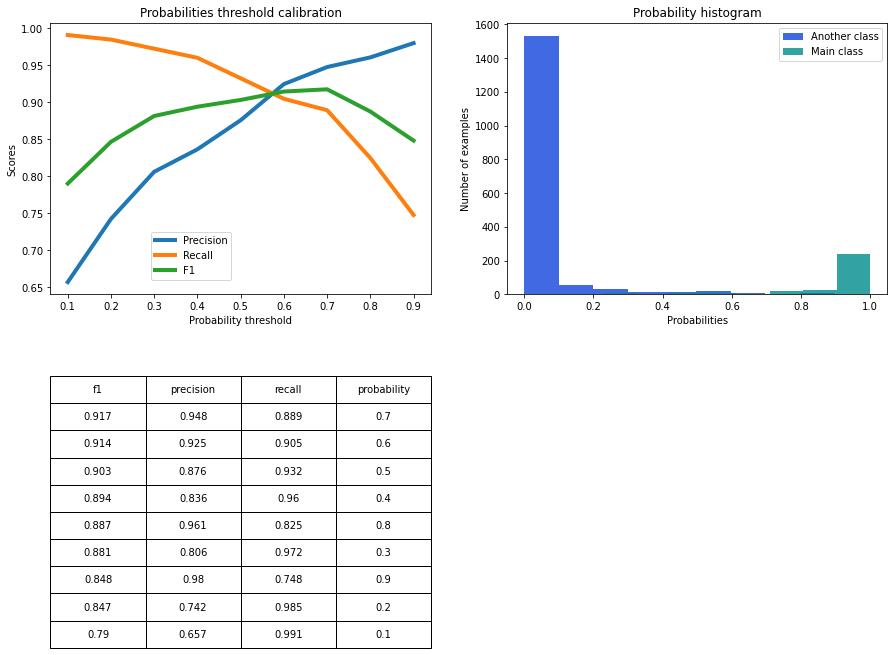

In [98]:
# let's see if calibration is needed
# to get higher f1, recall and precision we have to 
show_proba_calibration_plots(final_test, y_test)

### CatBoost Model
Here we take all the same preprocessing steps except one-hot encoding

In [115]:
# let's repeat all necessary steps
df = pd.read_csv(data_root) # read
df = df.iloc[:, :-2] # remove redundant columns
df.drop_duplicates(inplace=True) # drop duplicates
df = reduce_memory(df, verbose=0) # reduce memory
df[TARGET_NAME] = df[TARGET_NAME].map({'Existing Customer': 0, 'Attrited Customer': 1}) # map target
df[TARGET_NAME] = df[TARGET_NAME].astype(np.uint8)
df.set_index('CLIENTNUM', drop=True, inplace=True) # set client id as index
# split
X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]
X['Age_Cut'] = pd.cut(X['Customer_Age'], [15,25,35,45,65,90], labels=[1,2,3,4,5]).astype(np.uint8)
X['Total_Trans_Amt_Cut'] = pd.cut(X['Total_Trans_Amt'], [-1, 11e3, 100e3], labels=[0,1]).astype(np.uint8)
X['Total_Ct_Chng_Q4_Q1_Cut'] = pd.cut(X['Total_Ct_Chng_Q4_Q1'], [-1, 1, 10], labels=[0,1]).astype(np.uint8)
X['Total_Trans_Ct_Cut'] = pd.cut(X['Total_Trans_Ct'], [-1, 61, 1000], labels=[0,1]).astype(np.uint8)
X['Total_Amt_Chng_Q4_Q1_Cut'] = pd.cut(X['Total_Amt_Chng_Q4_Q1'], [-1,1,10], labels=[0,1]).astype(np.uint8)
X['Avg_Utilization_Ratio_Cut'] = pd.cut(X['Avg_Utilization_Ratio'], [-1, 0.15, 10], labels=[0,1]).astype(np.uint8)
X['Contacts_Count_12_mon_Cut'] = pd.cut(X['Contacts_Count_12_mon'], [-1,3,1000], labels=[0,1]).astype(np.uint8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train, random_state=123)
print(f'Train size: {X_train.shape}, Validation size: {X_valid.shape}, Test size: {X_test.shape}')

Train size: (7290, 26), Validation size: (811, 26), Test size: (2026, 26)


In [100]:
# categorical columns; we are using Pool as a good practice, it is not necessary here as the dataset is small
cat_cols = X_train.select_dtypes(include=['category']).columns.tolist() # exclude=[np.number]

train_pool = Pool(X_train, y_train, cat_features=cat_cols)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_cols)

In [101]:
### select from catboost shaps
def select_features(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    print('Algorithm:', algorithm)
    model = CatBoostClassifier(iterations=200, auto_class_weights='Balanced', random_seed=0)
    summary = model.select_features(
        train_pool,
        eval_set=valid_pool,
        features_for_select=list(range(train_pool.num_col())),
        num_features_to_select=21,
        steps=steps,
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=False,
        logging_level='Silent',
        plot=True
    )
    print('Selected features:', summary['selected_features_names'])
    return summary

feature_set = select_features(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=3)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Selected features: ['Customer_Age', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Total_Trans_Amt_Cut', 'Total_Trans_Ct_Cut', 'Total_Amt_Chng_Q4_Q1_Cut', 'Avg_Utilization_Ratio_Cut', 'Contacts_Count_12_mon_Cut']


In [116]:
X = X[feature_set['selected_features_names']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train, random_state=123)
print(f'Train size: {X_train.shape}, Validation size: {X_valid.shape}, Test size: {X_test.shape}')

Train size: (7290, 21), Validation size: (811, 21), Test size: (2026, 21)


In [117]:
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

train_pool = Pool(X_train, y_train, cat_features=cat_cols)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_cols)

In [ ]:
params_model = {
    'eval_metric': 'AUC', 
    'iterations': 1000,
    'silent': True,
    'one_hot_max_size': 15,
    'early_stopping_rounds': 10,
    'allow_writing_files': False,
    'use_best_model': True,
    'random_seed': 123,
    }

In [ ]:
def objective(trial):
    param_trials = {
                    'depth': trial.suggest_int('depth', 3, 9),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
                    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1., 5.),
                    'bagging_temperature': trial.suggest_float('bagging_temperature', 1., 3.),
                    'subsample': trial.suggest_float('subsample', 0.3, 1.),
                    'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.3, 1.),
                    'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
                    'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
                    'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
                    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 255),
                    'max_leaves': trial.suggest_int('max_leaves', 5, 64),
                    }
    param_trials.update(params_model)
    if param_trials['grow_policy'] == 'SymmetricTree':
        param_trials['min_data_in_leaf'] = None
        param_trials['max_leaves'] = None
    if param_trials['grow_policy'] == 'Depthwise':
        param_trials['max_leaves'] = None
    if param_trials['grow_policy'] != 'SymmetricTree':
        param_trials['boosting_type'] = 'Plain'
    
    opt_model = CatBoostClassifier(**param_trials)
    opt_model.fit(train_pool, eval_set=valid_pool)
    
    y_pred = opt_model.predict_proba(X_valid)[:,1]
    score = roc_auc_score(y_valid, y_pred)
    
    return score

In [ ]:
optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(sampler=TPESampler(seed=123), direction="maximize")
study.optimize(objective, n_trials=400, timeout=6000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
for key, value in trial.params.items():
    print(f'{key}: {value}')

In [124]:
params_model = {
                'eval_metric': 'AUC', 
                'iterations': 1000,
                'auto_class_weights': 'Balanced',
                'silent': True,
                'one_hot_max_size': 15,
                'early_stopping_rounds': 10,
                'grow_policy': 'Lossguide',
                'allow_writing_files': False,
                'use_best_model': True,
                'random_seed': 123,
                'depth': 6,
                'learning_rate': 0.22540078356329593, 
                'l2_leaf_reg': 4.428018995596401,
                'bagging_temperature': 2.6188806639292928, 
                'subsample': 0.8228965922419746, 
                'colsample_bylevel': 0.6873908043676631, 
                'boosting_type': 'Plain',
                'min_data_in_leaf': 19,
                'max_leaves': 40,
                }

In [125]:
X_fold, X_test, y_fold, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)

In [126]:
# get result probabilities on 3 folds
test_results, train_roc, test_pred, train_f1, train_acc = [], [], [], [], []
skf = StratifiedKFold(n_splits=3)
models = []

for train_index, valid_index in skf.split(X_fold, y_fold):
    X_train, X_valid = X_fold.iloc[train_index, :], X_fold.iloc[valid_index, :]
    y_train, y_valid = y_fold.iloc[train_index], y_fold.iloc[valid_index]

    cat = CatBoostClassifier(cat_features=cat_cols, **params_model)

    cat.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    test_labels = cat.predict(X_test)
    test_pred.append(test_labels)
    
    train_proba = cat.predict_proba(X_train)[:,1]
    train_roc.append(roc_auc_score(y_train, train_proba))
    
    train_labels = cat.predict(X_train)
    train_f1.append(f1_score(y_train, train_labels))
    train_acc.append(accuracy_score(y_train, train_labels))
    
    pred_test = cat.predict_proba(X_test)[:,1]
    test_results.append(pred_test)
    print(classification_report(y_test, test_labels, digits=3), '\n', '='*30)
    models.append(cat)

final_test = np.array(test_results).mean(axis=0)
test_pred = vote(test_pred, weights=[1.,1.,1.])

              precision    recall  f1-score   support

           0      0.986     0.984     0.985      1701
           1      0.915     0.926     0.920       325

    accuracy                          0.974      2026
   macro avg      0.950     0.955     0.953      2026
weighted avg      0.974     0.974     0.974      2026
 
              precision    recall  f1-score   support

           0      0.986     0.984     0.985      1701
           1      0.915     0.926     0.920       325

    accuracy                          0.974      2026
   macro avg      0.950     0.955     0.953      2026
weighted avg      0.974     0.974     0.974      2026
 
              precision    recall  f1-score   support

           0      0.985     0.982     0.984      1701
           1      0.909     0.920     0.914       325

    accuracy                          0.972      2026
   macro avg      0.947     0.951     0.949      2026
weighted avg      0.973     0.972     0.972      2026
 


In [127]:
cat = models[0]  # choose best model

In [108]:
# mean metrics values from k-fold training
print(f'train mean accuracy: {np.array(train_acc).mean():.4f}, test accuracy: {accuracy_score(y_test, test_pred):.4f}')
print(f'train mean f1: {np.array(train_f1).mean():.4f}, test f1: {f1_score(y_test, test_pred):.4f}')
print(f'train mean auc: {np.array(train_roc).mean():.4f}, test auc: {roc_auc_score(y_test, final_test):.4f}')
# cat model also overfits a bit, but also not critically

train mean accuracy: 0.9994, test accuracy: 0.9768
train mean f1: 0.9983, test f1: 0.9280
train mean auc: 1.0000, test auc: 0.9959


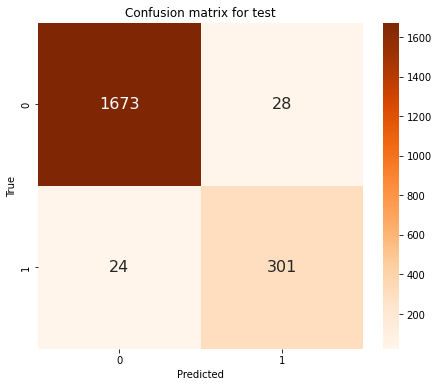

In [109]:
cm = confusion_matrix(y_true=y_test, y_pred=cat.predict(X_test))
conf_df = pd.DataFrame(cm, index=[0,1], columns=[0,1])
plt.figure(figsize=(16,6))
plt.subplot(121)
sns.heatmap(conf_df, cmap="Oranges", annot=True, annot_kws={"size": 16}, fmt='d')
plt.title('Confusion matrix for test')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

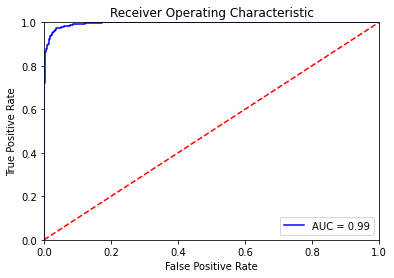

In [110]:
roc_plot(y_test, cat.predict_proba(X_test)[:,1])

In [111]:
# shap importancies
shap_values = cat.get_feature_importance(train_pool, type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

In [112]:
shap.initjs()
shap.force_plot(expected_value, shap_values[0,:], X_fold.iloc[0,:])
# so client with big sum of transactions is more likely to stay, otherhand with low frequency of transations and
# long time inactive he is going to churn

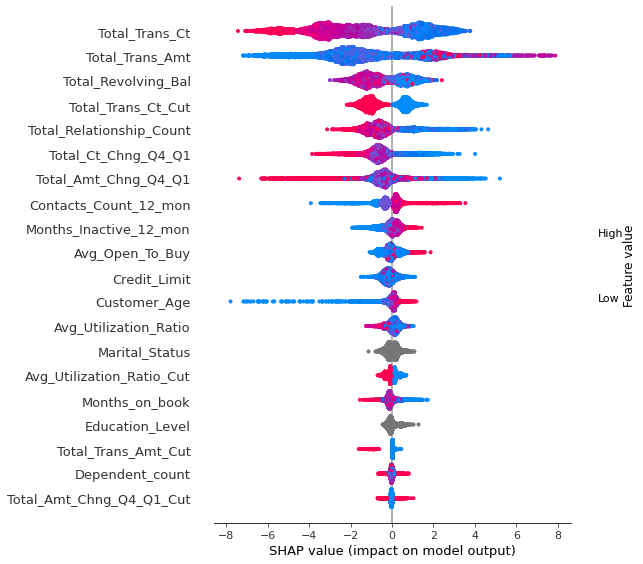

In [118]:
shap.initjs()
shap.summary_plot(shap_values, X_train) # initial after selection, not from kfold loop!
# so Total_Trans_Ct if high -> leads to churn, big sums of transactions leads client to stay, High amount of contancts
# leads client to stay

#### Let's try to retrain models during kfold splits (redefine X_train ... after cell below)

In [122]:
# experiment
params_model = {
                'eval_metric': 'AUC', 
                'iterations': 1000,
                'auto_class_weights': 'Balanced',
                'silent': True,
                'one_hot_max_size': 15,
                'early_stopping_rounds': 10,
                'grow_policy': 'SymmetricTree',
                'allow_writing_files': False,
                'use_best_model': True,
                'random_seed': 123,
                'depth': 6,
                'learning_rate': 0.22540078356329593, 
                'l2_leaf_reg': 4.428018995596401,
                'bagging_temperature': 2.6188806639292928, 
                'subsample': 0.8228965922419746, 
                'colsample_bylevel': 0.6873908043676631, 
                'boosting_type': 'Plain',
                'min_data_in_leaf': 19,
                }

cats = [CatBoostClassifier(cat_features=cat_cols, **params_model)] * 3
test_results, train_roc, test_pred, train_f1, train_acc = [], [], [], [], []
skf = StratifiedKFold(n_splits=3)

i = 0
for train_index, valid_index in skf.split(X_fold, y_fold):
    X_train, X_valid = X_fold.iloc[train_index, :], X_fold.iloc[valid_index, :]
    y_train, y_valid = y_fold.iloc[train_index], y_fold.iloc[valid_index]
    
    if i == 0:
        cats[i].fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    else: 
        cats[i].fit(X_train, y_train, eval_set=[(X_valid, y_valid)], init_model=cats[i-1])
    test_labels = cats[i].predict(X_test)
    test_pred.append(test_labels)
    
    train_proba = cats[i].predict_proba(X_train)[:,1]
    train_roc.append(roc_auc_score(y_train, train_proba))
    
    train_labels = cats[i].predict(X_train)
    train_f1.append(f1_score(y_train, train_labels))
    train_acc.append(accuracy_score(y_train, train_labels))
    
    pred_test = cats[i].predict_proba(X_test)[:,1]
    test_results.append(pred_test)
    print(classification_report(y_test, test_labels, digits=3), '\n', '='*30)
    i+=1

final_test = np.array(test_results).mean(axis=0)
test_pred = vote(test_pred, weights=[1.,1.,1.])

              precision    recall  f1-score   support

           0      0.988     0.977     0.982      1701
           1      0.886     0.935     0.910       325

    accuracy                          0.970      2026
   macro avg      0.937     0.956     0.946      2026
weighted avg      0.971     0.970     0.971      2026
 
              precision    recall  f1-score   support

           0      0.989     0.972     0.981      1701
           1      0.867     0.945     0.904       325

    accuracy                          0.968      2026
   macro avg      0.928     0.958     0.943      2026
weighted avg      0.970     0.968     0.968      2026
 
              precision    recall  f1-score   support

           0      0.989     0.972     0.980      1701
           1      0.865     0.945     0.903       325

    accuracy                          0.967      2026
   macro avg      0.927     0.958     0.942      2026
weighted avg      0.969     0.967     0.968      2026
 


#### Mean predictions of retrained model from k-folds

In [123]:
print(f'train mean accuracy: {np.array(train_acc).mean():.4f}, test accuracy: {accuracy_score(y_test, test_pred):.4f}')
print(f'train mean f1: {np.array(train_f1).mean():.4f}, test accuracy: {f1_score(y_test, test_pred):.4f}')
print(f'train mean auc: {np.array(train_roc).mean():.4f}, test auc: {roc_auc_score(y_test, final_test):.4f}')
# f1-score a bit better

train mean accuracy: 0.9824, test accuracy: 0.9679
train mean f1: 0.9474, test accuracy: 0.9043
train mean auc: 0.9980, test auc: 0.9950


#### Calibration of probabilities

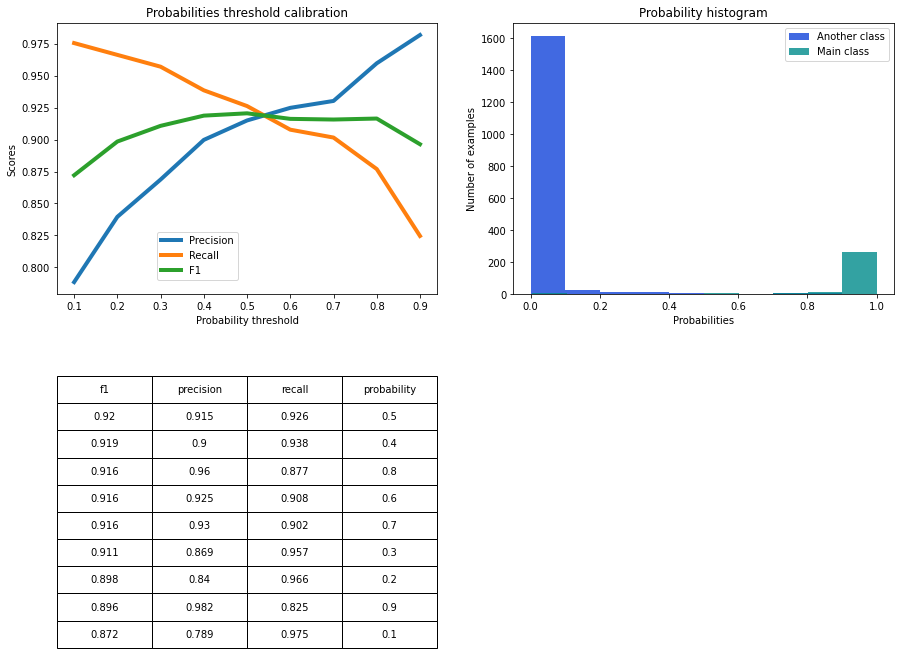

In [128]:
show_proba_calibration_plots(cat.predict_proba(X_test)[:,1], y_test)  # cat from first KFolds

In [129]:
test_probas = cat.predict_proba(X_test)[:,1]
test_preds_calibrated = np.where(test_probas >= 0.3, 1, 0)
train_preds_calibrated = np.where(cat.predict_proba(X_fold)[:,1] > 0.6, 1, 0)
report(y_fold, train_preds_calibrated, y_test, test_preds_calibrated, cat.predict_proba(X_fold)[:,1], test_probas)
# get more close precision and recall

Train
               precision    recall  f1-score   support

           0      0.993     0.994     0.993      6799
           1      0.967     0.963     0.965      1302

    accuracy                          0.989      8101
   macro avg      0.980     0.978     0.979      8101
weighted avg      0.989     0.989     0.989      8101

Test
               precision    recall  f1-score   support

           0      0.992     0.972     0.982      1701
           1      0.869     0.957     0.911       325

    accuracy                          0.970      2026
   macro avg      0.930     0.965     0.946      2026
weighted avg      0.972     0.970     0.970      2026

Train ROC_AUC: 0.998, Test ROC_AUC: 0.995
Confusion Matrix 
 col_0              0    1
Attrition_Flag           
0               1654   47
1                 14  311


#### Plot ROC_AUC curve

In [130]:
def plot_ROC(y_train_true, y_train_prob, y_test_true, y_test_prob):
    '''
    a funciton to plot the ROC curve for train labels and test labels.
    Use the best threshold found in train set to classify items in test set.
    '''
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train_true, y_train_prob, pos_label=True)
    sum_sensitivity_specificity_train = tpr_train + (1-fpr_train)
    best_threshold_id_train = np.argmax(sum_sensitivity_specificity_train)
    best_threshold = thresholds_train[best_threshold_id_train]
    best_fpr_train = fpr_train[best_threshold_id_train]
    best_tpr_train = tpr_train[best_threshold_id_train]
    y_train = y_train_prob > best_threshold

    cm_train = confusion_matrix(y_train_true, y_train)
    acc_train = accuracy_score(y_train_true, y_train)
    auc_train = roc_auc_score(y_train_true, y_train)

    print('Train Accuracy: %s ' %acc_train)
    print('Train AUC: %s ' %auc_train)
    print('Train Confusion Matrix:')
    print(cm_train)

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(121)
    curve1 = ax.plot(fpr_train, tpr_train)
    curve2 = ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    dot = ax.plot(best_fpr_train, best_tpr_train, marker='o', color='black')
    ax.text(best_fpr_train, best_tpr_train, s = '(%.3f,%.3f)' %(best_fpr_train, best_tpr_train))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Train), AUC = %.4f'%auc_train)

    fpr_test, tpr_test, thresholds_test = roc_curve(y_test_true, y_test_prob, pos_label =True)

    y_test = y_test_prob > best_threshold

    cm_test = confusion_matrix(y_test_true, y_test)
    acc_test = accuracy_score(y_test_true, y_test)
    auc_test = roc_auc_score(y_test_true, y_test)

    print('Test Accuracy: %s ' %acc_test)
    print('Test AUC: %s ' %auc_test)
    print('Test Confusion Matrix:')
    print(cm_test)

    tpr_score = float(cm_test[1][1])/(cm_test[1][1] + cm_test[1][0])
    fpr_score = float(cm_test[0][1])/(cm_test[0][0]+ cm_test[0][1])

    ax2 = fig.add_subplot(122)
    curve1 = ax2.plot(fpr_test, tpr_test)
    curve2 = ax2.plot([0, 1], [0, 1], color='navy', linestyle='--')
    dot = ax2.plot(fpr_score, tpr_score, marker='o', color='black')
    ax2.text(fpr_score, tpr_score, s = '(%.3f,%.3f)' %(fpr_score, tpr_score))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Test), AUC = %.4f'%auc_test)
    plt.savefig('ROC', dpi = 500)
    plt.show()

    return best_threshold

Train Accuracy: 0.9837057153437847 
Train AUC: 0.9831515500268969 
Train Confusion Matrix:
[[6690  109]
 [  23 1279]]
Test Accuracy: 0.9649555774925962 
Test AUC: 0.9654402387735721 
Test Confusion Matrix:
[[1641   60]
 [  11  314]]


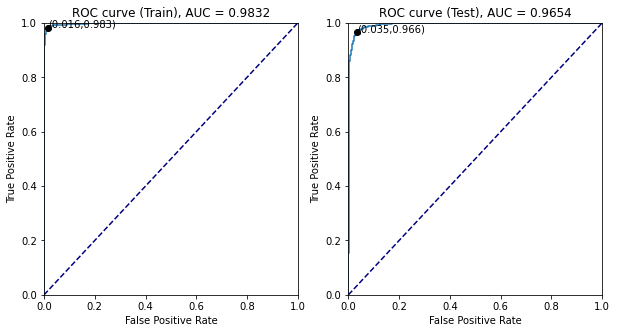

0.1998247528025782

In [131]:
plot_ROC(y_fold, cat.predict_proba(X_fold)[:,1], y_test, cat.predict_proba(X_test)[:,1])
# best threshold from this family of model = 0.47 ~ 0.5, the best ability to separate two classes

#### Plot AUC_PR-curve

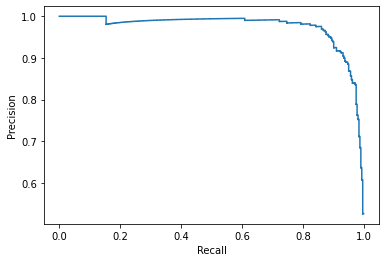

In [132]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

precision, recall, _ = precision_recall_curve(y_test, cat.predict_proba(X_test)[:,1])
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

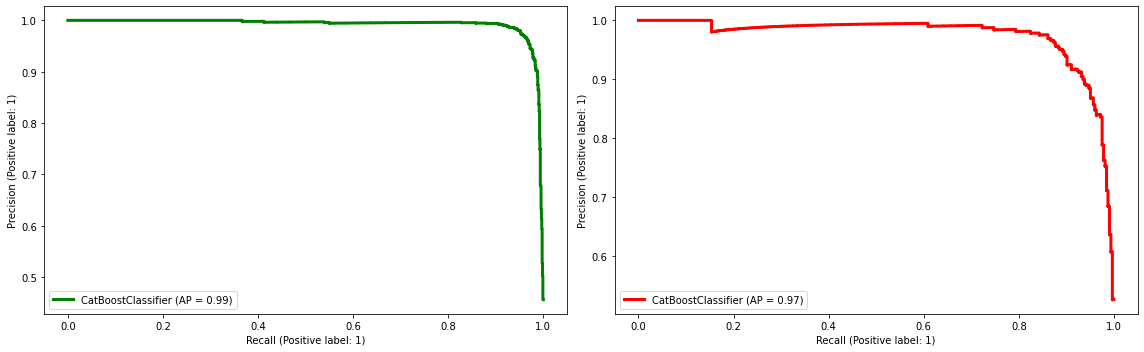

In [133]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax = ax.flatten()
PrecisionRecallDisplay.from_estimator(cat, X_fold, y_fold, color='green', lw=3, ax=ax[0])
PrecisionRecallDisplay.from_estimator(cat, X_test, y_test, color='red', lw=3, ax=ax[1])
plt.tight_layout()
plt.show()

In [134]:
from sklearn.metrics import average_precision_score

train_probas = cat.predict_proba(X_fold)[:,1]

for line in ['micro', 'samples', 'weighted', 'macro']:
    print(f"Train Average precision score_{line}: {average_precision_score(y_fold, train_probas, average=line):.4f}")
    print(f"Test Average precision score_{line}: {average_precision_score(y_test, test_probas, average=line):.4f}")
    print('-'*30)

Train Average precision score_micro: 0.9918
Test Average precision score_micro: 0.9746
------------------------------
Train Average precision score_samples: 0.9918
Test Average precision score_samples: 0.9746
------------------------------
Train Average precision score_weighted: 0.9918
Test Average precision score_weighted: 0.9746
------------------------------
Train Average precision score_macro: 0.9918
Test Average precision score_macro: 0.9746
------------------------------


In [135]:
# another F-score calibration
precision, recall, thresholds = precision_recall_curve(y_test, test_probas)

fscore = 2 * precision * recall / (precision + recall)
ix = np.argmax(fscore)

print(f'Best threshold: {thresholds[ix]:.3f}, F-score: {fscore[ix]:.3f}, Recall: {recall[ix]:.3f}, Precision: {precision[ix]:.3f}.')

Best threshold: 0.478, F-score: 0.922, Recall: 0.932, Precision: 0.913.


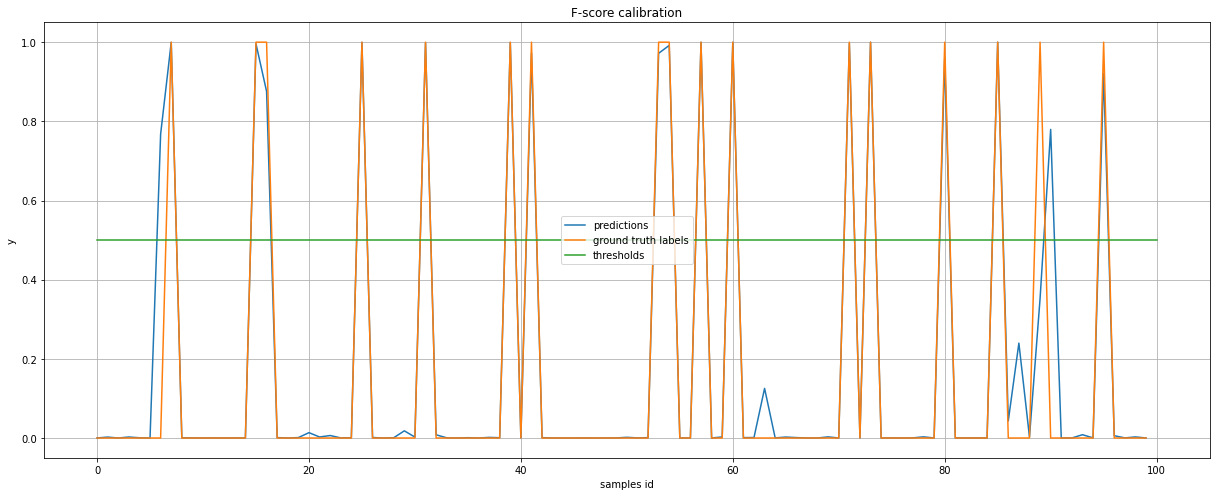

In [136]:
plt.figure(figsize=(17,7))
plt.title('F-score calibration')
plt.plot(test_probas[:100], label='predictions')
plt.plot(y_test.values[:100], label='ground truth labels')
plt.plot([0, 100], [0.5, 0.5], label='thresholds')
plt.ylabel('y')
plt.xlabel('samples id')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

#### Let's try another approach: weighted sequential ensemble learing - AdaBoost

In [137]:
# again repeat all necessary steps
df = pd.read_csv(data_root) # read
df = df.iloc[:, :-2] # remove redundant columns
df.drop_duplicates(inplace=True) # drop duplicates
df = reduce_memory(df, verbose=0) # reduce memory
df[TARGET_NAME] = df[TARGET_NAME].map({'Existing Customer': 0, 'Attrited Customer': 1}) # map target
df[TARGET_NAME] = df[TARGET_NAME].astype(np.uint8)
df['Gender'] = df['Gender'].map({'M': 0, 'F': 1})
df['Gender'] = df['Gender'].astype(np.uint8)
df.set_index('CLIENTNUM', drop=True, inplace=True) # set client id as index
df = pd.get_dummies(df, prefix=['col1', 'col2', 'col3', 'col4'])
# as Ada Boost algorithm also uses Decision Trees, no data scaling is needed
# split
X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train, random_state=123)
print(f'Train size: {X_train.shape}, Validation size: {X_valid.shape}, Test size: {X_test.shape}')

Train size: (7290, 36), Validation size: (811, 36), Test size: (2026, 36)


In [138]:
model_params = {
                'random_state': 123,  
}

In [ ]:
def objective(trial):
    param_trials = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 800),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 2.),
                    'algorithm': trial.suggest_categorical('algorithm', ['SAMME', 'SAMME.R'])
                    }
    param_trials.update(model_params)
    opt_model = AdaBoostClassifier(**param_trials)
    opt_model.fit(X_train, y_train)
    
    y_pred = opt_model.predict_proba(X_valid)[:,1]
    score = roc_auc_score(y_valid, y_pred)
    
    return score

In [ ]:
optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(sampler=TPESampler(seed=123), direction="maximize")
study.optimize(objective, n_trials=300, timeout=6000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
for key, value in trial.params.items():
    print(f'{key}: {value}')

In [139]:
X_fold, X_test, y_fold, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)

In [140]:
model_params = {
                'random_state': 123,
                'n_estimators': 351,
                'learning_rate': 1.7243852737318626,
                'algorithm': 'SAMME',
}

In [141]:
# get result probabilities on 3 folds
test_results, train_roc, test_pred, train_f1, train_acc = [], [], [], [], []
skf = StratifiedKFold(n_splits=3)

for train_index, valid_index in skf.split(X_fold, y_fold):
    X_train, X_valid = X_fold.iloc[train_index, :], X_fold.iloc[valid_index, :]
    y_train, y_valid = y_fold.iloc[train_index], y_fold.iloc[valid_index]

    cat = AdaBoostClassifier(**model_params)

    cat.fit(X_train, y_train)
    test_labels = cat.predict(X_test)
    test_pred.append(test_labels)
    
    train_proba = cat.predict_proba(X_train)[:,1]
    train_roc.append(roc_auc_score(y_train, train_proba))
    
    train_labels = cat.predict(X_train)
    train_f1.append(f1_score(y_train, train_labels))
    train_acc.append(accuracy_score(y_train, train_labels))
    
    pred_test = cat.predict_proba(X_test)[:,1]
    test_results.append(pred_test)

final_test = np.array(test_results).mean(axis=0)
test_pred = vote(test_pred, weights=[1.,1.,1.])

In [142]:
print(f'train mean accuracy: {np.array(train_acc).mean():.4f}, test accuracy: {accuracy_score(y_test, test_pred):.4f}')
print(f'train mean f1: {np.array(train_f1).mean():.4f}, test accuracy: {f1_score(y_test, test_pred):.4f}')
print(f'train mean auc: {np.array(train_roc).mean():.4f}, test auc: {roc_auc_score(y_test, final_test):.4f}')
# ada boost is a bit worse

train mean accuracy: 0.9774, test accuracy: 0.9659
train mean f1: 0.9291, test accuracy: 0.8927
train mean auc: 0.9972, test auc: 0.9906
